### 개요
- 다음 분기에 어떤 게임을 설계해야 할까

#*🚨* **data description**

- `Name`: 게임의 이름입니다.

- `Platform`: 게임이 지원되는 플랫폼의 이름입니다.

- `Year`: 게임이 출시된 연도입니다.

- `Genre`: 게임의 장르입니다.

- `Publisher`: 게임을 배급한 회사입니다.

- `NA_Sales`: 북미지역에서의 출고량입니다.

- `EU_Sales`: 유럽지역에서의 출고량입니다.

- `JP_Sales`: 일본지역에서의 출고량입니다.

- `Other_Sales`: 기타지역에서의 출고량입니다.

In [1]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/ngha6475/code_states_project/main/section_1/data/vgames2.csv", index_col=0)
raw_df.reset_index(drop=True, inplace=True)

In [3]:
raw_df.head(5)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [5]:
raw_df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

### 결측치 제거
- Year, Genre, Publisher 에서 결측치 확인
- 각 컬럼의 결측값을 다른 값으로 대체하기 어렵다고 판단함
- 데이터 양에 비해서 결측치가 적기 때문에 결측치를 제거하고 분석해도 이상이 없다고 판단함

In [6]:
df = raw_df.copy().dropna()
df.reset_index(drop=True, inplace=True)

In [7]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

### 컬럼 타입 변경
- NA_Sales, EU_Sales, JP_Sales, Other_Sales 타입을 object -> float 타입으로 변경.
- 값에 'K', 'M' 과 같은 문자열이 섞여 있음.
- 단위를 Million 으로 통일

In [8]:
df['Other_Sales']

0           0
1        0.01
2           0
3           0
4        0.04
         ... 
16236    0.01
16237       0
16238    0.13
16239    0.03
16240    0.01
Name: Other_Sales, Length: 16241, dtype: object

In [9]:
import re

def has_errors(inputString):
    return bool(re.search('[a-zA-Z]+', inputString)) # 영어 문자 찾기

In [10]:
error_condition = df['Other_Sales'].apply(has_errors)
error_sales = df[error_condition]
error_sales

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
62,SD Gundam Force,GBA,2004.0,Shooter,Namco Bandai Games,0.01,0,0,0M
71,Teenage Mutant Ninja Turtles,XB,2003.0,Action,Konami Digital Entertainment,0.22,0.06,0,0.01M
206,Harry Potter and the Sorcerer's Stone,XB,2003.0,Action,Electronic Arts,0.05,0.02,0,0M
217,Dragon Quest IV: Michibikareshi Monotachi,PS,2001.0,Role-Playing,Enix Corporation,0,0,1.2,0.01M
240,Seaman 2: Peking Genjin Ikusei Kit,PS2,2007.0,Simulation,Sega,0,0,0.06,0M
...,...,...,...,...,...,...,...,...,...
15793,World Championship Poker: Featuring Howard Led...,PS2,2006.0,Misc,Oxygen Interactive,0.82,0.64,0,0.22M
15795,DJ Hero,Wii,2009.0,Misc,Activision,0.47,0.23,0K,70K
16036,Project Setsuna,PSV,2016.0,Role-Playing,Square Enix,0,0,0.05,0K
16060,Yu-Gi-Oh! Ultimate Masters: World Championship...,GBA,2006.0,Misc,Konami Digital Entertainment,0.14,0.05,0.07,0.01M


In [11]:
# 판매량의 K와 M 문자열 처리
df['NA_Sales'] = df['NA_Sales'].replace({'K': '*0.001', 'M': ""}, regex=True).map(pd.eval)
df['EU_Sales'] = df['EU_Sales'].replace({'K': '*0.001', 'M': ""}, regex=True).map(pd.eval)
df['JP_Sales'] = df['JP_Sales'].replace({'K': '*0.001', 'M': ""}, regex=True).map(pd.eval)
df['Other_Sales'] = df['Other_Sales'].replace({'K': '*0.001', 'M': ""}, regex=True).map(pd.eval)

In [12]:
# 전세계 판매량을 반영하기 위해, 새로운 feature 생성
df["Total_Sales"] = df.NA_Sales + df.EU_Sales + df.JP_Sales + df.Other_Sales

In [13]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16236,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16237,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16238,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16239,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16241 non-null  object 
 1   Platform     16241 non-null  object 
 2   Year         16241 non-null  float64
 3   Genre        16241 non-null  object 
 4   Publisher    16241 non-null  object 
 5   NA_Sales     16241 non-null  float64
 6   EU_Sales     16241 non-null  float64
 7   JP_Sales     16241 non-null  float64
 8   Other_Sales  16241 non-null  float64
 9   Total_Sales  16241 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.2+ MB


### 데이터 중복 확인 및 제거
- 'Name', 'Platform', 'Year', 'Genre', 'Publisher' 의 값은 같고 각 지역의 판매량만 다른 데이터들에 대해서 판매량을 다 더해준 후 하나의 행으로 합쳐준다.

In [15]:
df.shape

(16241, 10)

In [16]:
df[df.duplicated(keep=False)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales


In [17]:
dup_df = df[df.duplicated(subset=['Name', 'Platform', 'Year', 'Genre', 'Publisher'], keep=False)]

dup_df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
7199,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,2.11,0.23,0.0,0.22,2.56
8543,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,0.00,0.01,0.0,0.00,0.01


In [18]:
dup_sales_sum_df = dup_df.groupby(['Name', 'Platform', 'Year', 'Genre', 'Publisher']).sum().reset_index()

dup_sales_sum_df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,2.11,0.24,0.0,0.22,2.57


In [19]:
df.drop_duplicates(subset=['Name', 'Platform', 'Year', 'Genre', 'Publisher'], keep=False, inplace=True)

In [20]:
df = pd.concat([df, dup_sales_sum_df])

In [21]:
df.reset_index(drop=True, inplace=True)

In [22]:
df.shape

(16240, 10)

### 1. Year
- 20 이하 : 2000년대를 의미하므로, 앞에 20을 추가
- 80 이상 : 1900년대를 의미하므로, 앞에 19를 추가

In [23]:
df['Year'].value_counts()

2009.0    1418
2008.0    1413
2010.0    1246
2007.0    1192
2011.0    1123
          ... 
13.0         2
12.0         2
86.0         1
2020.0       1
94.0         1
Name: Year, Length: 62, dtype: int64

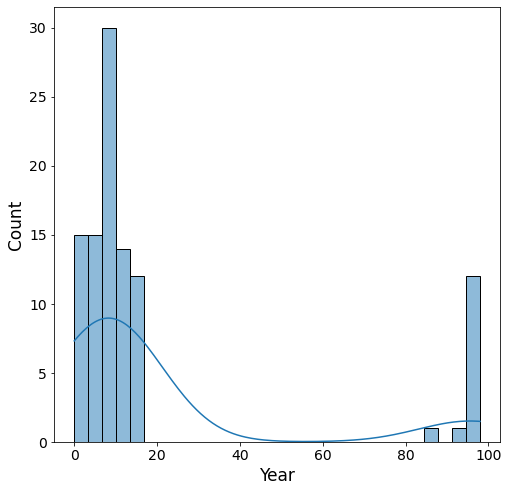

In [24]:
f, ax = plt.subplots(1, 1, figsize=(8,8))
sns.histplot(x = df[(df['Year'] <= 100)]['Year'], kde=True)
ax.set_xlabel("Year", fontsize=17)
ax.set_ylabel("Count", fontsize=17)
ax.tick_params(labelsize=14)

plt.show()

In [25]:
df.query("Year <= 20")['Year'] + 2000

72       2009.0
210      2011.0
299      2015.0
758      2003.0
1001     2009.0
          ...  
15271    2002.0
15491    2015.0
15754    2008.0
15799    2008.0
16040    2000.0
Name: Year, Length: 86, dtype: float64

In [26]:
df.query("Year > 80 and Year < 100")['Year'] + 1900

79       1997.0
894      1996.0
2383     1996.0
3423     1998.0
4274     1986.0
4705     1995.0
4737     1995.0
10111    1997.0
10491    1996.0
11102    1995.0
14259    1998.0
14468    1995.0
15639    1994.0
16125    1998.0
Name: Year, dtype: float64

In [27]:
def year_eda(x):
    if x <= 20:
        return x + 2000
    elif (x > 80) & (x < 100):
        return x + 1900
    else: return x

In [28]:
df['Year'] = df['Year'].apply(year_eda)

In [29]:
df['Year'] = df['Year'].astype(int)

In [30]:
df['Year'].value_counts()

2009    1428
2008    1423
2010    1253
2007    1195
2011    1133
2006    1005
2005     934
2002     826
2003     774
2004     740
2012     651
2015     611
2014     580
2013     545
2001     480
1998     377
2000     348
2016     342
1999     336
1997     289
1996     262
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1984      14
1985      14
1980       8
2017       3
2020       1
Name: Year, dtype: int64

In [31]:
df.head(5)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


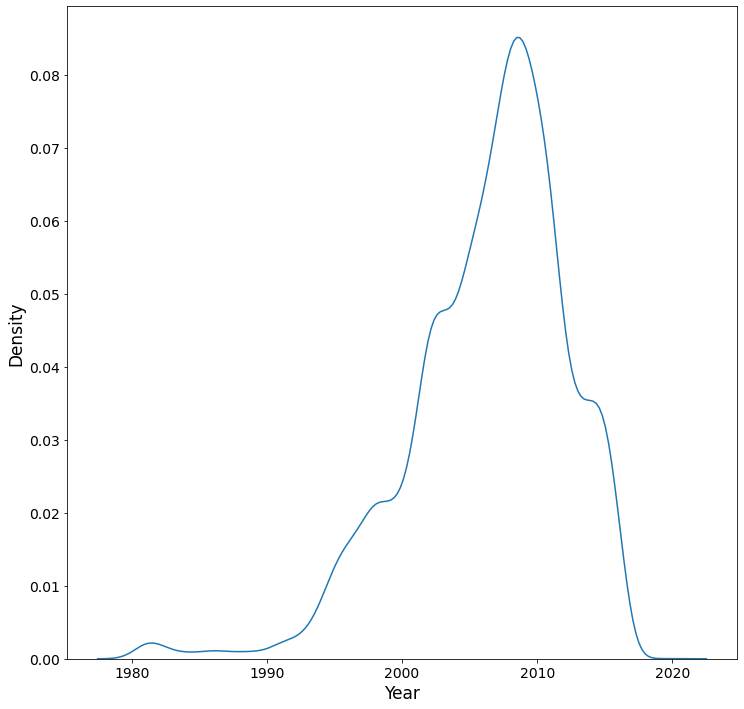

In [32]:
f, ax = plt.subplots(1, 1, figsize=(12,12))
sns.kdeplot('Year', data=df)
ax.set_xlabel("Year", fontsize=17)
ax.set_ylabel("Density", fontsize=17)
ax.tick_params(labelsize=14)

plt.show()

- 데이터를 보면 대부분 2000 ~ 2010년대의 게임들이다.

In [33]:
df[df['Year']>=2000].shape

(14272, 10)

In [34]:
# 2000년대 이후에 출시된 게임들의 전세계 판매량, 각 지역에 따른 판매량 비교
subset_year = df.groupby(by="Year").sum()
subset_year = subset_year[subset_year.index >= 2000] # 2000년대 이후 출시된 게임

subset_year

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Year,,,,,
2000,94.42,52.73,42.77,11.62,201.54
2001,172.86,94.36,38.77,22.62,328.61
2002,215.56,109.50,41.76,27.25,394.07
2003,193.39,103.76,33.76,25.99,356.90
2004,215.46,104.80,41.65,46.92,408.83
2005,240.92,121.55,54.16,40.49,457.12
2006,261.17,129.24,71.40,52.69,514.50
2007,310.64,160.14,60.29,77.53,608.60
2008,350.89,183.57,60.26,81.69,676.41


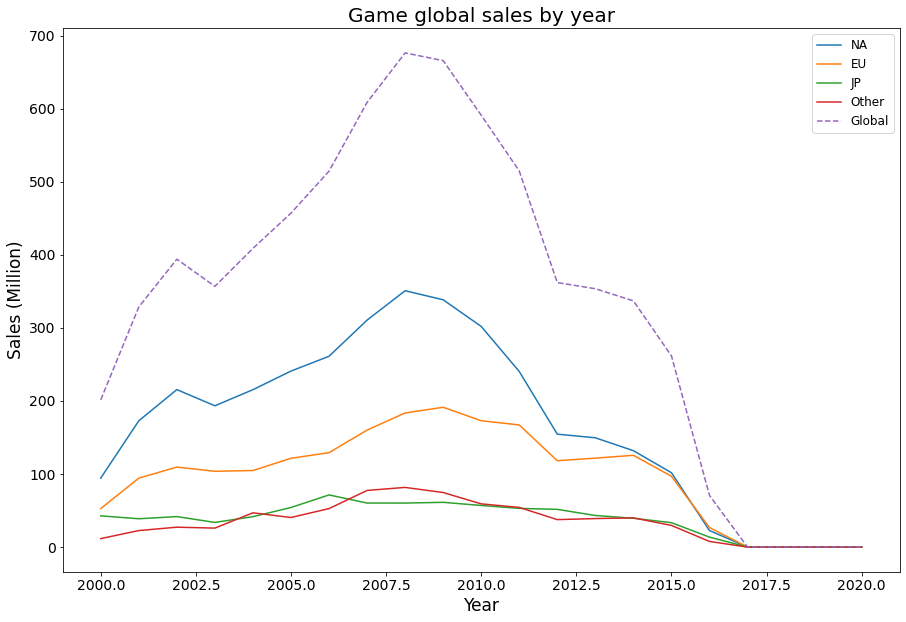

In [35]:
plt.figure(figsize = (15,10))
ax = plt.gca()
plt.plot(subset_year.index, subset_year.NA_Sales, label = "NA")
plt.plot(subset_year.index, subset_year.EU_Sales, label = "EU")
plt.plot(subset_year.index, subset_year.JP_Sales, label = "JP")
plt.plot(subset_year.index, subset_year.Other_Sales, label = "Other")
plt.plot(subset_year.index, subset_year.Total_Sales, '--',label = "Global")

plt.legend(loc='best', fontsize=12)
plt.xlabel('Year', fontsize = 17)
plt.ylabel('Sales (Million)', fontsize = 17)
plt.title('Game global sales by year', fontsize = 20)
plt.tick_params(labelsize=14)
plt.show()

- 전체적으로 북미 지역의 게임 판매량이 제일 많으며, 그 다음으로는 유럽 지역의 게임 판매량이 많다.
- 북미 시장과 유럽시장을 Taget으로 하는 것이 좋다.

### 2. Platform
- Platform의 종류를 크게 휴대용기기, 콘솔, PC 3개로 나눌수 있다.
- Platform_Groups 컬럼을 만들어 종류 별로 그룹을 나눈다.

In [36]:
df['Platform'].value_counts()

DS      2127
PS2     2121
PS3     1298
Wii     1284
X360    1231
PSP     1193
PS      1185
PC       935
XB       799
GBA      784
GC       541
3DS      498
PSV      409
PS4      335
N64      313
SNES     239
XOne     212
SAT      173
WiiU     143
2600     115
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: Platform, dtype: int64

In [37]:
# numpy.where(조건문, True 값, False 값)
df['Platform_Groups'] = np.where(
    df.Platform == 'PC', 'PC',
    np.where(
        (df.Platform =='DS') | (df.Platform =='3DS') | (df.Platform =='GB') |
        (df.Platform =='GBA') | (df.Platform =='GG') | (df.Platform =='PSP') |
        (df.Platform =='PSV') | (df.Platform =='WS'), 'Portable', 'Console'
    )
)

In [38]:
df.head(5)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04,Portable
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18,Console
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02,Portable
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04,Portable
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25,Console


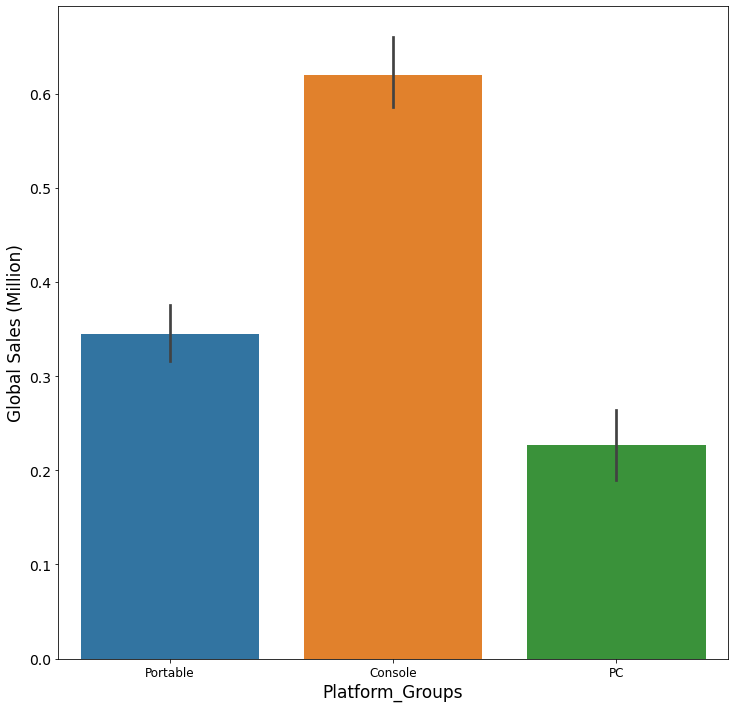

In [39]:
# 2000년대 이 후 Platform Group 에 따른 전세계 판매량 비교
f, ax = plt.subplots(1,1, figsize=(12, 12))
sns.barplot(x = 'Platform_Groups', y='Total_Sales', data = df[df['Year']>=2000])
ax.set_xlabel("Platform_Groups", fontsize=17)
ax.set_ylabel('Global Sales (Million)', fontsize=17)
ax.tick_params(labelsize=14)
plt.xticks(fontsize=12)

plt.show()

- 콘솔 게임의 전세계 판매량이 제일 많다.

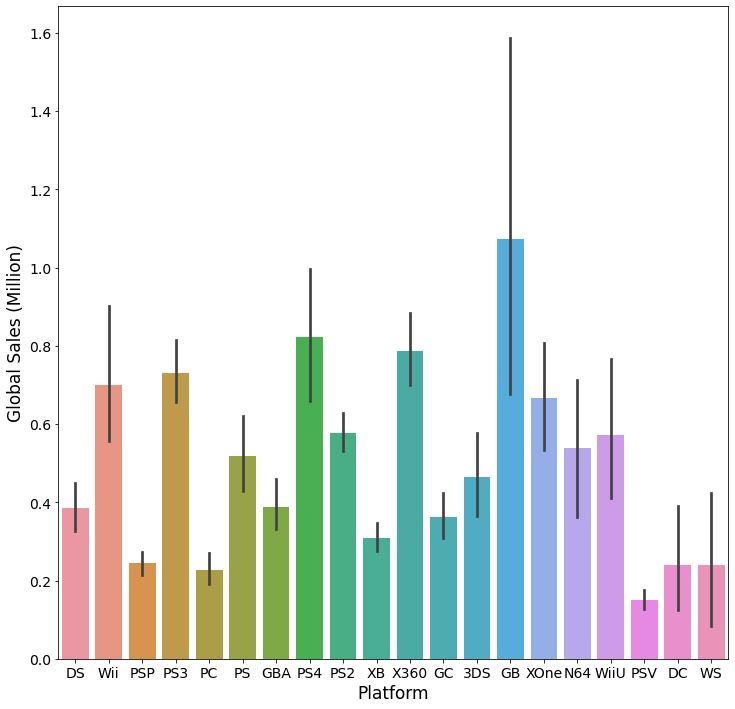

In [40]:
# 2000년대 이후 Platform에 따른 전세계 판매량 비교
f, ax = plt.subplots(1,1, figsize=(12, 12))
sns.barplot(x = 'Platform', y='Total_Sales', data = df[df['Year']>=2000])
ax.set_xlabel("Platform", fontsize=17)
ax.set_ylabel('Global Sales (Million)', fontsize=17)
ax.tick_params(labelsize=14)

plt.show()

- 세부적으로 보면 GB (휴대용 기기)가 전세계적으로 판매량이 제일 많지만,<br>
PS4, X360, PS3, Wii 등 콘솔 게임이 전체적으로 판매량이 많다.

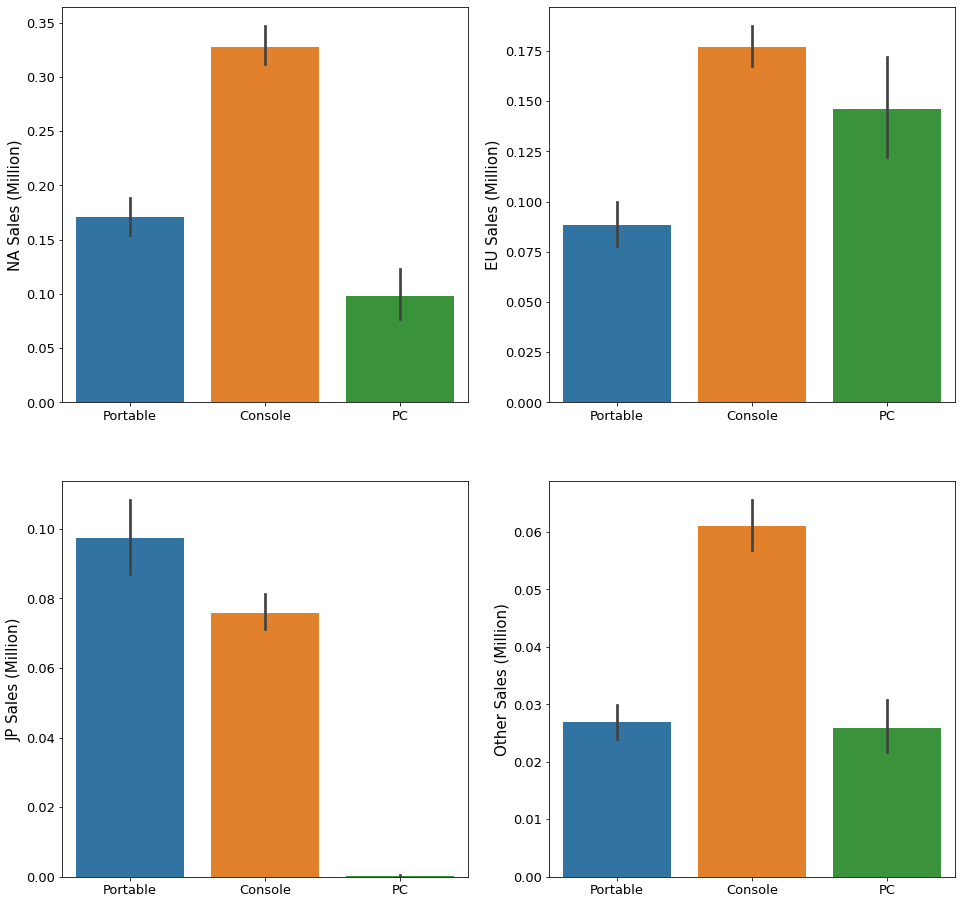

In [41]:
# 2000년대 이후 Platform에 따른 각 지역 판매량 비교
f, ax = plt.subplots(2,2, figsize=(16, 16))
sns.barplot(x = 'Platform_Groups', y='NA_Sales', data=df, ax=ax[0,0])
ax[0,0].set_ylabel('NA Sales (Million)', fontsize=15)
ax[0,0].set_xlabel(' ')
ax[0,0].tick_params(labelsize=13)

sns.barplot(x = 'Platform_Groups', y='EU_Sales', data=df, ax=ax[0,1])
ax[0,1].set_ylabel('EU Sales (Million)', fontsize=15)
ax[0,1].set_xlabel(' ')
ax[0,1].tick_params(labelsize=13)

sns.barplot(x = 'Platform_Groups', y='JP_Sales', data=df, ax=ax[1,0])
ax[1,0].set_ylabel('JP Sales (Million)', fontsize=15)
ax[1,0].set_xlabel(' ')
ax[1,0].tick_params(labelsize=13)

sns.barplot(x = 'Platform_Groups', y='Other_Sales', data=df, ax=ax[1,1])
ax[1,1].set_ylabel('Other Sales (Million)', fontsize=15)
ax[1,1].set_xlabel(' ')
ax[1,1].tick_params(labelsize=13)

plt.show()

- 북미 지역과 기타 지역의 경우, 콘솔 게임의 판매량이 높다.
- 유럽 지역은 콘솔 게임이 가장 판매량이 많지만 전세계적으로 판매량이 제일 낮은 PC게임의 판매량이 높게 나타났다.
- 일본 지역은 콘솔 게임보다 휴대용 기기 게임의 판매량이 더 높고, PC 게임의 판매량은 매우 적다.
- 전체적인 판매량은 북미 지역이 제일 많다.


In [42]:
df[df.duplicated(subset=['Name'], keep=False)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04,Portable
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25,Console
6,JASF: Jane's Advanced Strike Fighters,PC,2011,Simulation,Deep Silver,0.02,0.01,0.00,0.00,0.03,PC
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011,Action,THQ,0.04,0.03,0.00,0.01,0.08,Console
15,Mini Ninjas,PS3,2009,Action,Eidos Interactive,0.14,0.16,0.00,0.06,0.36,Console
...,...,...,...,...,...,...,...,...,...,...,...
16234,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20,Console
16236,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79,Console
16237,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38,Portable
16238,The King of Fighters '95,PS,1996,Fighting,Sony Computer Entertainment,0.00,0.00,0.16,0.01,0.17,Console


In [43]:
df[df.duplicated(subset=['Name', 'Platform'], keep=False)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups
1298,Need for Speed: Most Wanted,X360,2012,Racing,Electronic Arts,0.62,0.80,0.01,0.15,1.58,Console
2621,Need for Speed: Most Wanted,PC,2005,Racing,Electronic Arts,0.02,0.23,0.00,0.05,0.30,PC
12266,Need for Speed: Most Wanted,X360,2005,Racing,Electronic Arts,1.00,0.17,0.02,0.10,1.29,Console
13512,Need for Speed: Most Wanted,PC,2012,Racing,Electronic Arts,0.00,0.06,0.00,0.02,0.08,PC


In [44]:
df[df.duplicated(subset=['Name', 'Platform', 'Year', 'Genre', 'Publisher'], keep=False)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups


In [45]:
# 멀티플랫폼으로 출시한 게임에 대한 특성 생성
# 대형 AAA급 게임의 경우는, 콘솔, PC에서 모두 플레이 할 수 있는 멀티플랫폼 게임을 출시하는 경우가 많다.
# 멀티플랫폼으로 출시된 경우도 매출에 영향을 줄 수 있으므로, 특성을 생성해 시각화 한다.
df["Multiplatform"] = df.duplicated(["Name"], keep=False) # 중복된 모든 행에 True 표시
df["Multiplatform"] = df["Multiplatform"].map({True: 1, False:0})

df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04,Portable,1
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18,Console,0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02,Portable,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04,Portable,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25,Console,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16235,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01,Portable,0
16236,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79,Console,1
16237,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38,Portable,1
16238,The King of Fighters '95,PS,1996,Fighting,Sony Computer Entertainment,0.00,0.00,0.16,0.01,0.17,Console,1


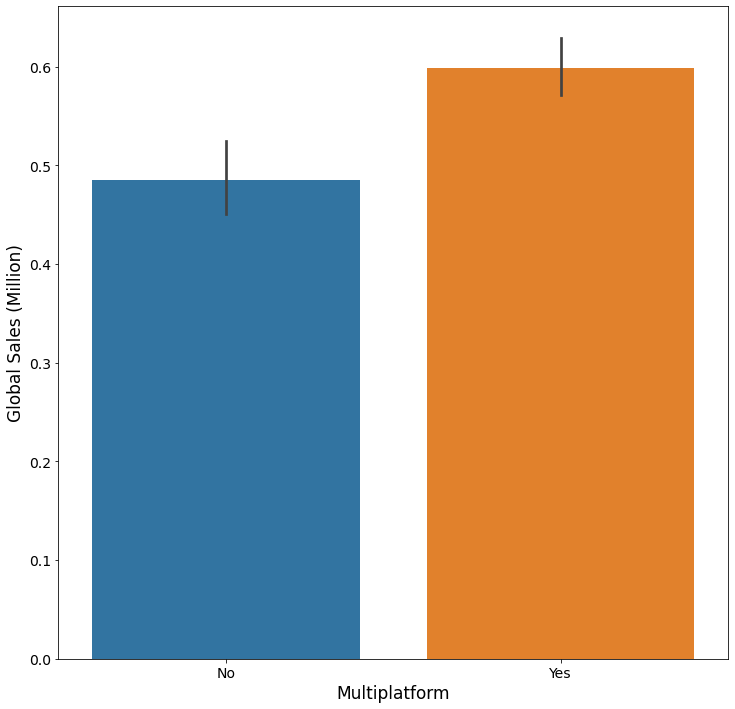

In [46]:
# 멀티플랫폼에 따른 총 판매량 비교
f, ax = plt.subplots(1,1, figsize=(12, 12))
sns.barplot(x='Multiplatform', y='Total_Sales', data=df)
ax.set_xlabel("Multiplatform", fontsize=17)
ax.set_ylabel('Global Sales (Million)', fontsize=17)
ax.set_xticklabels(['No', 'Yes'], fontsize=14)
ax.tick_params(labelsize=14)

plt.show()

- 멀티플랫폼으로 출시한 게임의 판매량이 더 높다.

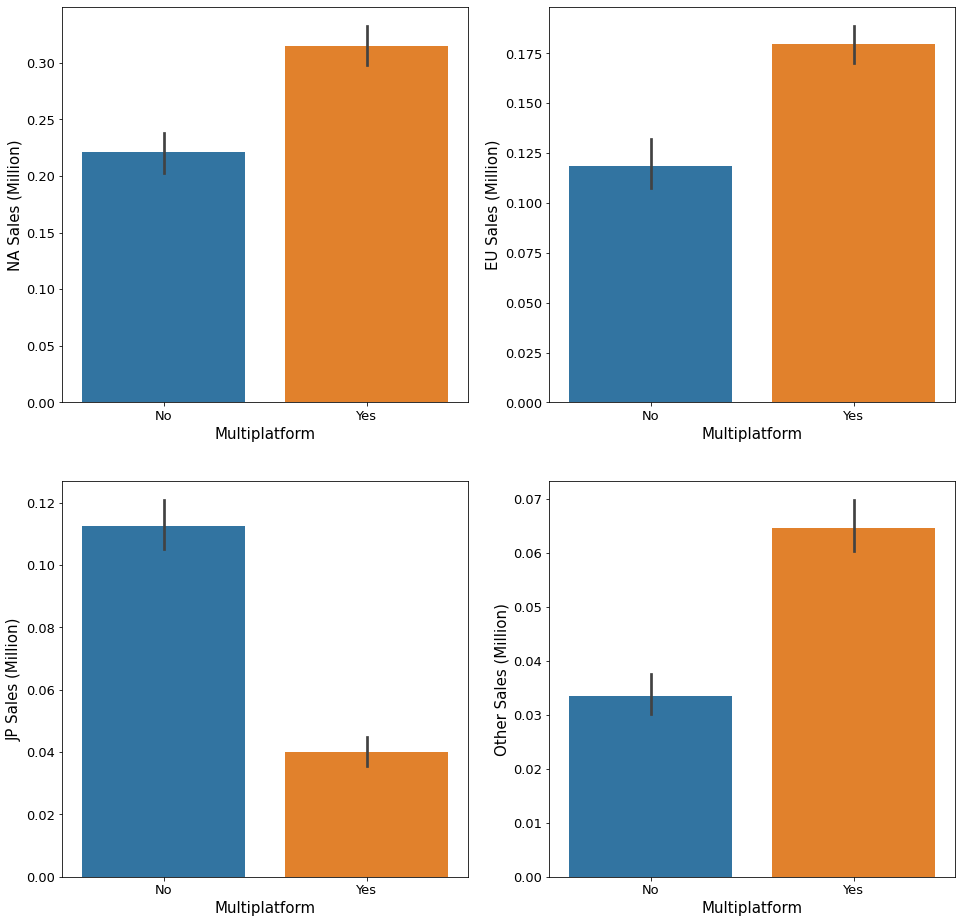

In [47]:
# 멀티플랫폼에 따른 각 지역 판매량 비교
f, ax = plt.subplots(2,2, figsize=(16, 16))
sns.barplot(x = 'Multiplatform', y='NA_Sales', data=df, ax=ax[0,0])
ax[0,0].set_ylabel('NA Sales (Million)', fontsize=15)
ax[0,0].set_xlabel('Multiplatform', fontsize=15)
ax[0,0].set_xticklabels(['No', 'Yes'], fontsize=13)
ax[0,0].tick_params(labelsize=13)

sns.barplot(x = 'Multiplatform', y='EU_Sales', data=df, ax=ax[0,1])
ax[0,1].set_ylabel('EU Sales (Million)', fontsize=15)
ax[0,1].set_xlabel('Multiplatform', fontsize=15)
ax[0,1].set_xticklabels(['No', 'Yes'], fontsize=13)
ax[0,1].tick_params(labelsize=13)

sns.barplot(x = 'Multiplatform', y='JP_Sales', data=df, ax=ax[1,0])
ax[1,0].set_ylabel('JP Sales (Million)', fontsize=15)
ax[1,0].set_xlabel('Multiplatform', fontsize=15)
ax[1,0].set_xticklabels(['No', 'Yes'], fontsize=13)
ax[1,0].tick_params(labelsize=13)

sns.barplot(x = 'Multiplatform', y='Other_Sales', data=df, ax=ax[1,1])
ax[1,1].set_ylabel('Other Sales (Million)', fontsize=15)
ax[1,1].set_xlabel('Multiplatform', fontsize=15)
ax[1,1].set_xticklabels(['No', 'Yes'], fontsize=13)
ax[1,1].tick_params(labelsize=13)

plt.show()

- 일본 지역을 제외하고는 멀티플랫폼으로 출시한 게임의 판매량이 높게 나타난다.

### 3. Genre

In [48]:
subset = df[df['Year']>=2000].groupby('Genre').sum().sort_values(by='Total_Sales', ascending=False)
subset = subset.reset_index()
genre_order =  subset.Genre.to_list()

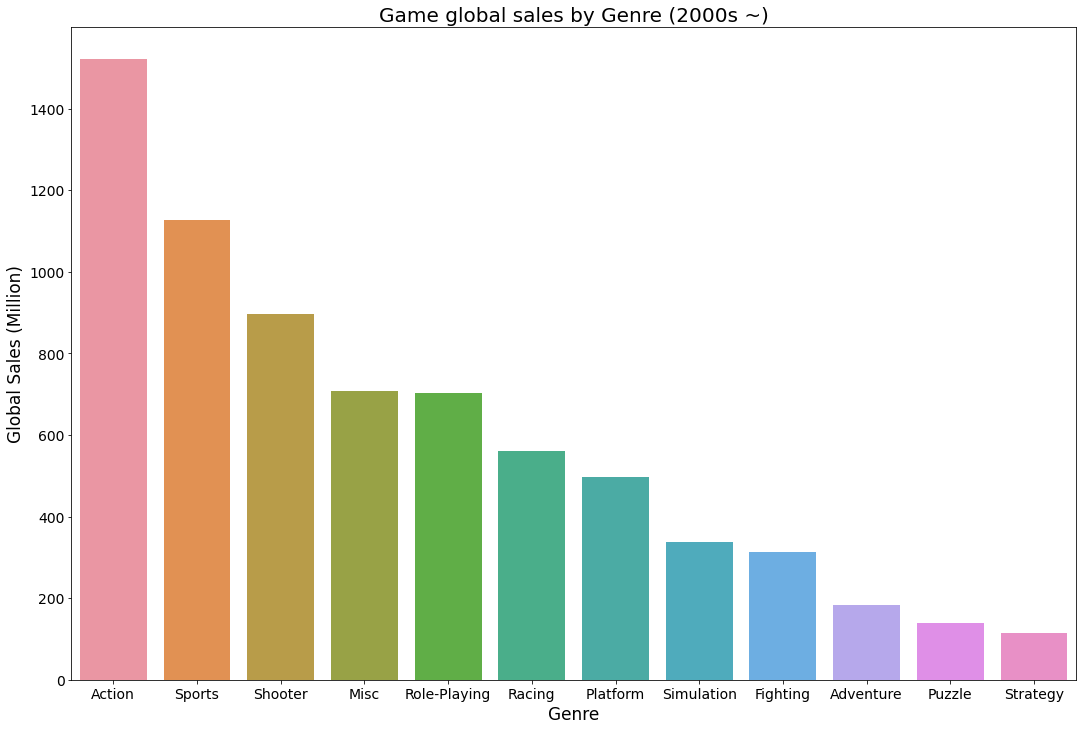

In [49]:
plt.figure(figsize = (18,12))
ax = plt.gca()
sns.barplot(x="Genre", y="Total_Sales", order=genre_order, data=subset)
ax.set_xlabel("Genre", fontsize=17)
ax.set_ylabel("Global Sales (Million)", fontsize=17)
ax.tick_params(labelsize=14)
plt.title('Game global sales by Genre (2000s ~)', fontsize = 20)

plt.show()

- 2000년대 이후 출시된 게임 중, 전세계적으로 가장 많이 팔린 게임의 장르는 Action 이다.

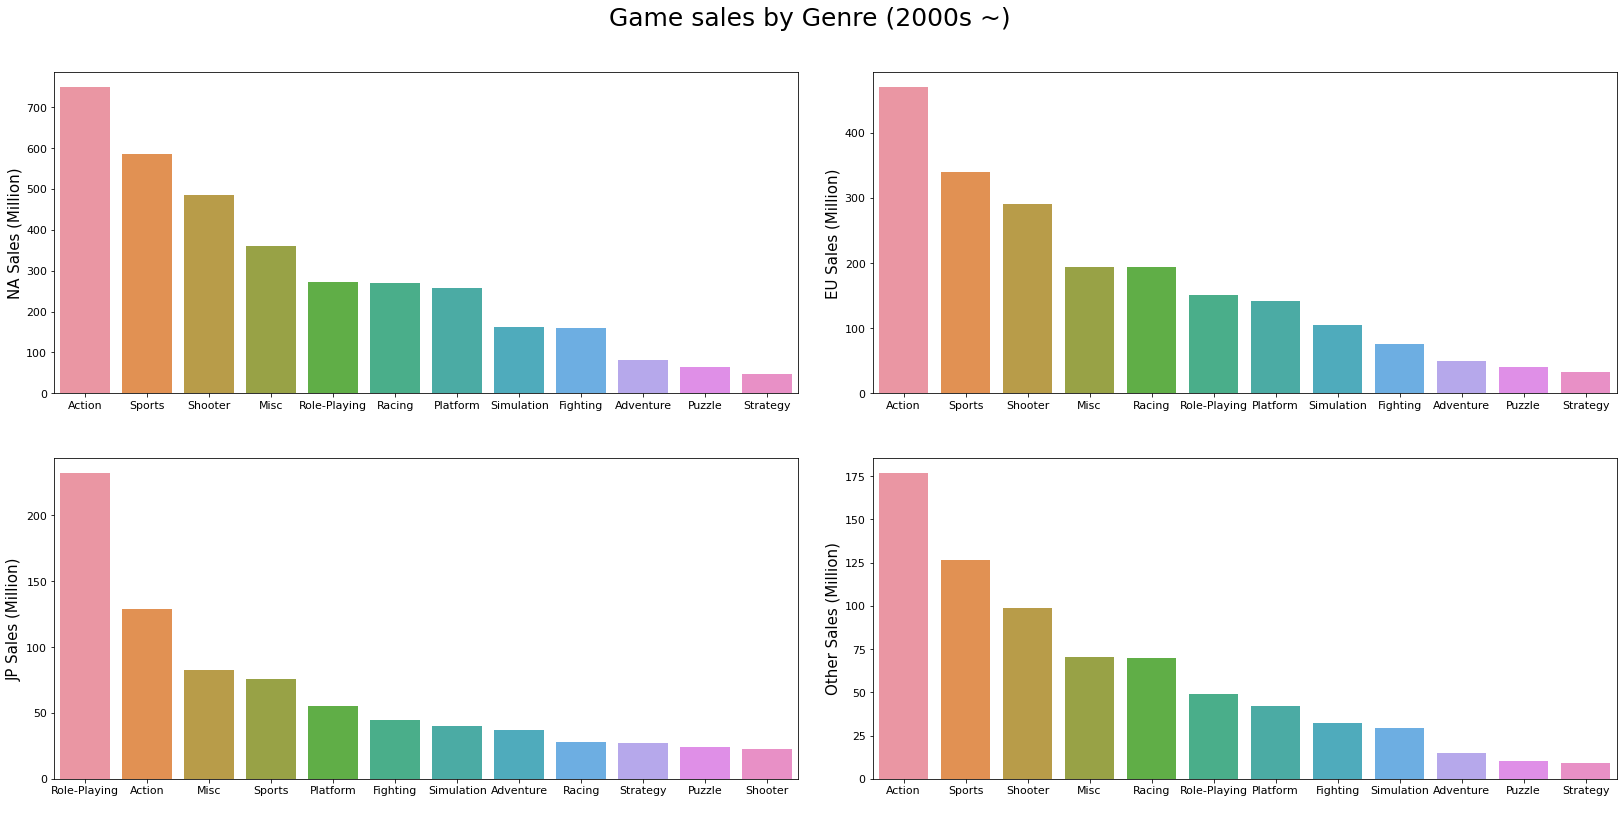

In [50]:
# 게임 장르에 따른 각 지역 판매량 비교
f, ax = plt.subplots(2,2, figsize=(28, 13))

subset = df[df['Year']>=2000].groupby('Genre').sum().sort_values(by='NA_Sales', ascending=False)
subset = subset.reset_index()
genre_order =  subset.Genre.to_list()
sns.barplot(x = 'Genre', y='NA_Sales', order = genre_order, data=subset, ax=ax[0,0])
ax[0,0].set_ylabel('NA Sales (Million)', fontsize=15)
ax[0,0].set_xlabel(' ')
ax[0,0].tick_params(labelsize=11)

subset = df[df['Year']>=2000].groupby('Genre').sum().sort_values(by='EU_Sales', ascending=False)
subset = subset.reset_index()
genre_order =  subset.Genre.to_list()
sns.barplot(x = 'Genre', y='EU_Sales', order = genre_order, data=subset, ax=ax[0,1])
ax[0,1].set_ylabel('EU Sales (Million)', fontsize=15)
ax[0,1].set_xlabel(' ')
ax[0,1].tick_params(labelsize=11)

subset = df[df['Year']>=2000].groupby('Genre').sum().sort_values(by='JP_Sales', ascending=False)
subset = subset.reset_index()
genre_order =  subset.Genre.to_list()
sns.barplot(x = 'Genre', y='JP_Sales', order = genre_order, data=subset, ax=ax[1,0])
ax[1,0].set_ylabel('JP Sales (Million)', fontsize=15)
ax[1,0].set_xlabel(' ')
ax[1,0].tick_params(labelsize=11)

subset = df[df['Year']>=2000].groupby('Genre').sum().sort_values(by='Other_Sales', ascending=False)
subset = subset.reset_index()
genre_order =  subset.Genre.to_list()
sns.barplot(x = 'Genre', y='Other_Sales', order = genre_order, data=subset, ax=ax[1,1])
ax[1,1].set_ylabel('Other Sales (Million)', fontsize=15)
ax[1,1].set_xlabel(' ')
ax[1,1].tick_params(labelsize=11)

f.suptitle('Game sales by Genre (2000s ~)', fontsize=25, y=0.95)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.show()

- 2000년대 이후 출시된 게임들의 각 지역별 장르별 판매량
  - 북미, 유럽, 그외 지역은 Action, Sports, Shooter 장르 순으로 판매량이 많다.
  - 일본은 Role-Playing, Action, Misc 장르 순으로 판매량이 많다.

### 4. Publisher
- Publisher 종류가 너무 많아 게임 판매량 Top 100 에서의 Publisher만 보기로 함.

In [51]:
df[df['Year']>=2000]['Publisher'].value_counts()

Electronic Arts                 1223
Activision                       908
Ubisoft                          894
Namco Bandai Games               836
Konami Digital Entertainment     696
                                ... 
Tripwire Interactive               1
RED Entertainment                  1
Athena                             1
Ertain                             1
NDA Productions                    1
Name: Publisher, Length: 456, dtype: int64

In [52]:
# 전세계 매출 Top 100 (2000년대 이후)
df_global_100 = df[df['Year']>=2000].sort_values(by='Total_Sales', ascending=False)
df_global_100.reset_index(drop = True,inplace=True)
df_global_100 = df_global_100.head(100)

df_global_100

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Console,0
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83,Console,0
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Console,0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,Portable,0
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01,Console,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,FIFA 15,PS4,2014,Sports,Electronic Arts,0.79,4.29,0.05,1.47,6.60,Console,1
96,Donkey Kong Country Returns,Wii,2010,Platform,Nintendo,3.25,1.84,1.03,0.47,6.59,Console,1
97,The Elder Scrolls V: Skyrim,PS3,2011,Role-Playing,Bethesda Softworks,2.55,2.71,0.25,1.05,6.56,Console,1
98,Assassin's Creed III,PS3,2012,Action,Ubisoft,2.64,2.56,0.16,1.14,6.50,Console,1


In [53]:
df_global_100.groupby(['Publisher']).sum().sort_values(by='Total_Sales', ascending=False)

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Multiplatform
Publisher,,,,,,,
Nintendo,76292,266.36,196.91,115.52,51.56,630.35,4
Activision,32176,94.67,59.91,3.72,21.64,179.94,16
Take-Two Interactive,20078,62.48,43.09,3.56,26.62,135.75,10
Electronic Arts,24120,24.71,47.41,1.38,14.72,88.22,12
Microsoft Game Studios,16065,58.13,19.69,0.70,5.95,84.47,3
Sony Computer Entertainment,12036,21.77,17.10,6.91,13.20,58.98,0
Ubisoft,10054,22.18,13.84,0.17,4.28,40.47,3
Bethesda Softworks,6037,10.05,8.72,0.59,3.00,22.36,3
Sega,2007,2.58,3.90,0.66,0.91,8.05,1


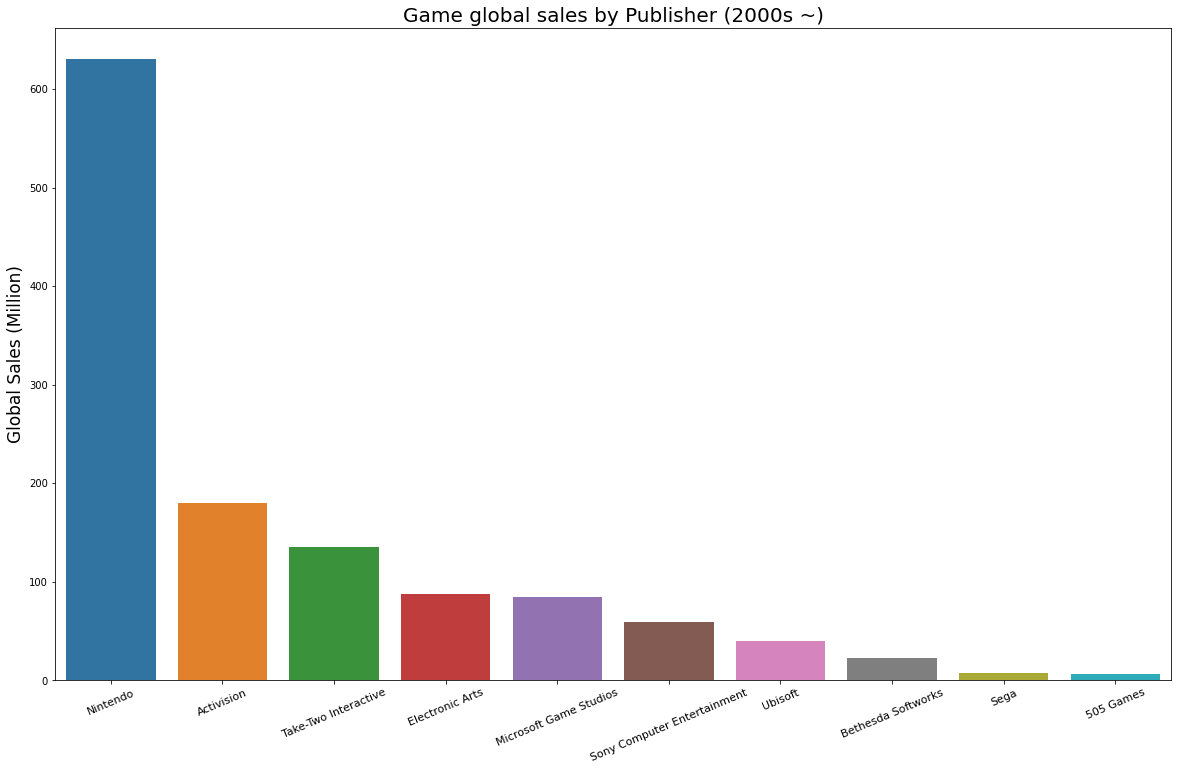

In [54]:
subset = df_global_100.groupby('Publisher').sum().sort_values(by='Total_Sales', ascending=False)
publisher_order =  subset.index.to_list()
subset = subset.reset_index()

plt.figure(figsize = (20,12))
ax = plt.gca()
sns.barplot(x='Publisher', y='Total_Sales', data=subset, order=publisher_order)
ax.set_ylabel("Global Sales (Million)", fontsize=17)
ax.set_xlabel(' ')

ax.set_xticklabels(publisher_order, rotation=23, fontsize = 11)
plt.title('Game global sales by Publisher (2000s ~)', fontsize = 20)
plt.show()

- Nintendo 사의 게임 판매량이 압도적으로 많다.

In [55]:
# 북미 매출 Top 100
df_NA_100 = df[df['Year']>=2000].sort_values(by='NA_Sales', ascending=False)
df_NA_100.reset_index(drop = True,inplace=True)
df_NA_100 = df_NA_100.head(100)

# 유럽 매출 Top 100
df_EU_100 = df[df['Year']>=2000].sort_values(by='EU_Sales', ascending=False)
df_EU_100.reset_index(drop = True,inplace=True)
df_EU_100 = df_EU_100.head(100)

# 일본 매출 Top 100
df_JP_100 = df[df['Year']>=2000].sort_values(by='JP_Sales', ascending=False)
df_JP_100.reset_index(drop = True,inplace=True)
df_JP_100 = df_JP_100.head(100)

# 그외 지역 매출 Top 100
df_Other_100 = df[df['Year']>=2000].sort_values(by='Other_Sales', ascending=False)
df_Other_100.reset_index(drop = True,inplace=True)
df_Other_100 = df_Other_100.head(100)

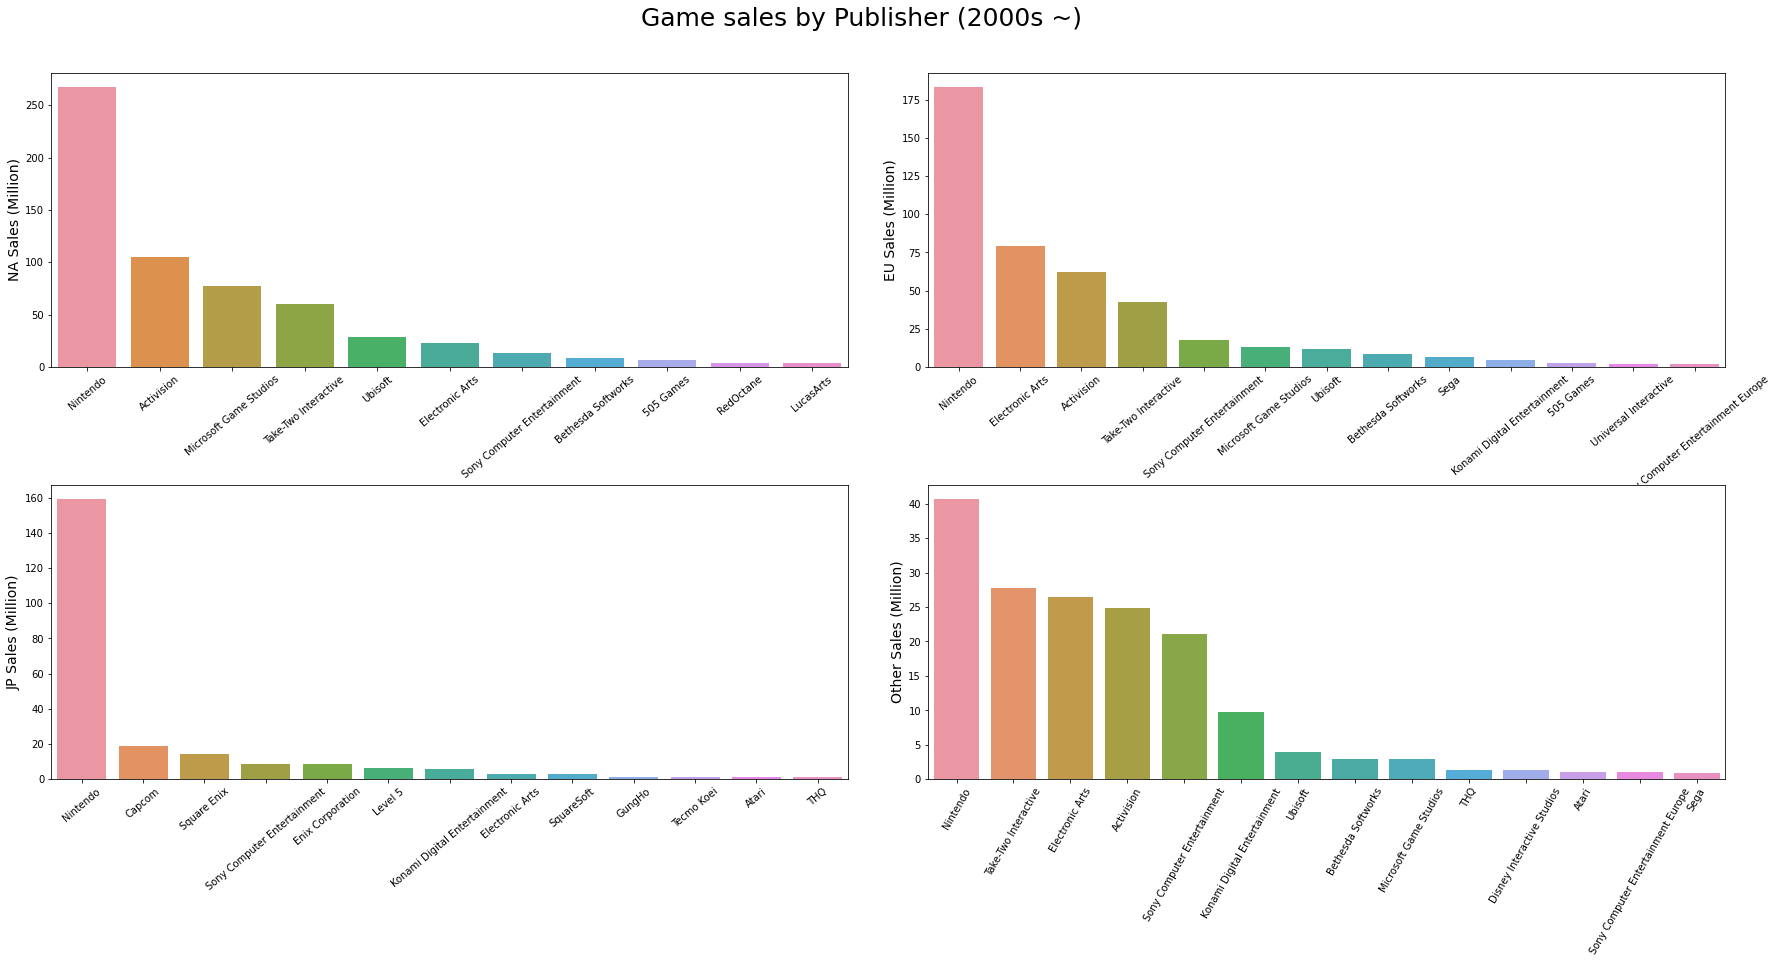

In [56]:
# 게임 출시회사에 따른 각 지역 판매량 비교
f, ax = plt.subplots(2,2, figsize=(30, 13))

subset = df_NA_100.groupby('Publisher').sum().sort_values(by='NA_Sales', ascending=False)
publisher_order =  subset.index.to_list()
subset = subset.reset_index()
sns.barplot(x='Publisher', y='NA_Sales', data=subset, order = publisher_order, ax=ax[0,0])
ax[0,0].set_ylabel('NA Sales (Million)', fontsize=14)
ax[0,0].set_xlabel(' ')
ax[0,0].set_xticklabels(publisher_order, rotation=40, fontsize = 10)

subset = df_EU_100.groupby('Publisher').sum().sort_values(by='EU_Sales', ascending=False)
publisher_order =  subset.index.to_list()
subset = subset.reset_index()
sns.barplot(x='Publisher', y='EU_Sales', data=subset, order=publisher_order, ax=ax[0,1])
ax[0,1].set_ylabel('EU Sales (Million)', fontsize=14)
ax[0,1].set_xlabel(' ')
ax[0,1].set_xticklabels(publisher_order, rotation=40, fontsize = 10)

subset = df_JP_100.groupby('Publisher').sum().sort_values(by='JP_Sales', ascending=False)
publisher_order =  subset.index.to_list()
subset = subset.reset_index()
sns.barplot(x='Publisher', y='JP_Sales', order = publisher_order, data=subset, ax=ax[1,0])
ax[1,0].set_ylabel('JP Sales (Million)', fontsize=14)
ax[1,0].set_xlabel(' ')
ax[1,0].set_xticklabels(publisher_order, rotation=40, fontsize = 10)

subset = df_Other_100.groupby('Publisher').sum().sort_values(by='Other_Sales', ascending=False)
publisher_order = subset.index.to_list()
subset = subset.reset_index()
sns.barplot(x='Publisher', y='Other_Sales', order = publisher_order, data=subset, ax=ax[1,1])
ax[1,1].set_ylabel('Other Sales (Million)', fontsize=14)
ax[1,1].set_xlabel(' ')
ax[1,1].set_xticklabels(publisher_order, rotation=60, fontsize = 10)

f.suptitle('Game sales by Publisher (2000s ~)', fontsize=25, y=0.95)
plt.subplots_adjust(wspace=0.1, hspace=0.4)

plt.show()

- 2000년대 이후 출시된 게임들의 Publisher별 각 지역들의 판매량
  - 전세계적으로 Nintendo 사가 판매량이 제일 높다.
  - 북미 지역은 Nintendo, Activision, Microsoft Game Studios 순으로 판매량이 높다.
  - 유럽 지역은 Nintendo, Electronic Arts, Activision 순으로 판매량이 높다.
  - 일본 지역은 Nintendo, Capcom, Square Enix 순으로 판매량이 높다.

### 5. Platform, Year

In [57]:
# 2000년대 이후에 출시된 게임들의 전세계 판매량, 각 지역에 따른 판매량 비교
subset_year_platform = df[df['Year']>=2000].groupby(by=["Year",'Platform_Groups']).sum()
subset_year_platform = subset_year_platform.reset_index()
subset_year_platform

,Year,Platform_Groups,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Multiplatform
0,2000,Console,84.95,47.75,33.73,9.95,176.38,81
1,2000,PC,3.03,1.44,0.00,0.18,4.65,1
2,2000,Portable,6.44,3.54,9.04,1.49,20.51,6
3,2001,Console,129.94,75.58,26.38,20.34,252.24,112
4,2001,PC,4.08,1.24,0.00,0.18,5.50,3
5,2001,Portable,38.84,17.54,12.39,2.10,70.87,26
6,2002,Console,167.55,89.22,29.55,25.07,311.39,340
7,2002,PC,5.03,3.17,0.00,0.37,8.57,4
8,2002,Portable,42.98,17.11,12.21,1.81,74.11,56
9,2003,Console,156.47,85.65,25.17,24.03,291.32,367


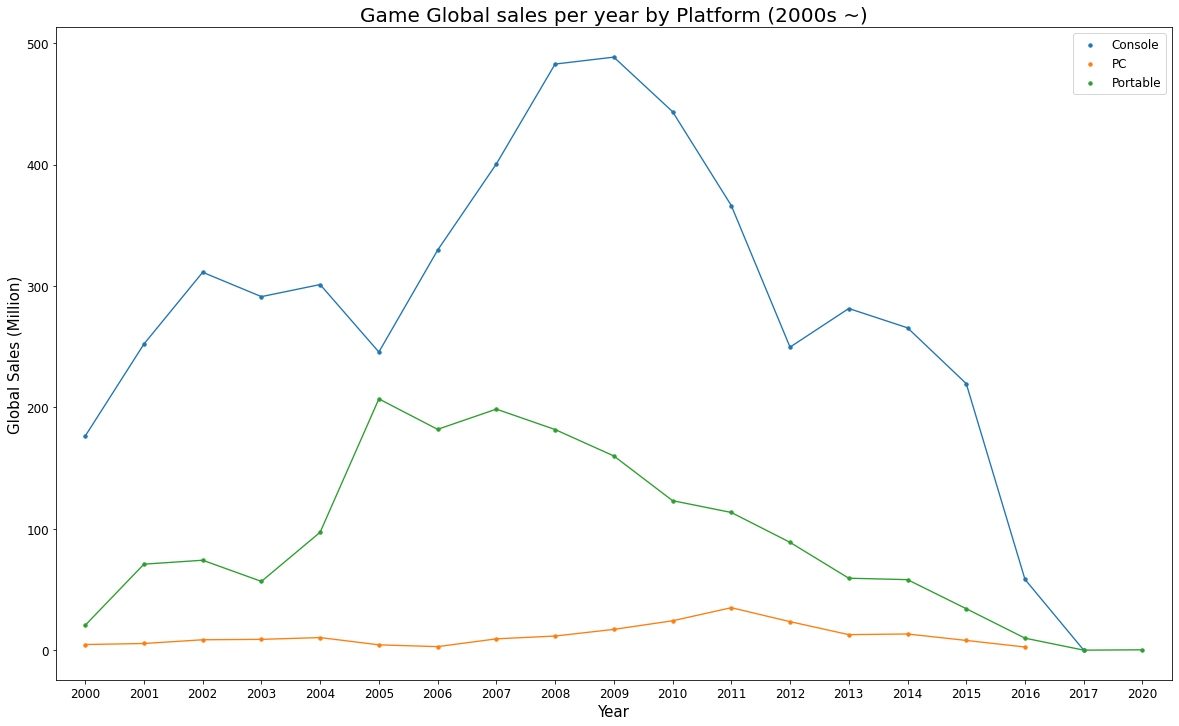

In [58]:
plt.figure(figsize = (20,12))
ax = plt.gca()
sns.pointplot(x='Year', y='Total_Sales', hue='Platform_Groups', scale = .5, data=subset_year_platform)
ax.tick_params(labelsize=12)

plt.legend(loc='best', fontsize=12)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Global Sales (Million)', fontsize = 15)
plt.title('Game Global sales per year by Platform (2000s ~)', fontsize = 20)

plt.show()

- 전세계적으로 보았을 때, 콘솔 게임이 게임 시장의 주요한 Platform이며, 그 다음으론 휴대용 기기이다.
- 콘솔 게임의 판매량은 2009년도에 최고치를 찍고, 급속하게 감소하고 있다.
- 휴대용 기기 게임의 판매량은 2005년도에 최고치를 찍고, 점차 감소하는 추세에 있다.

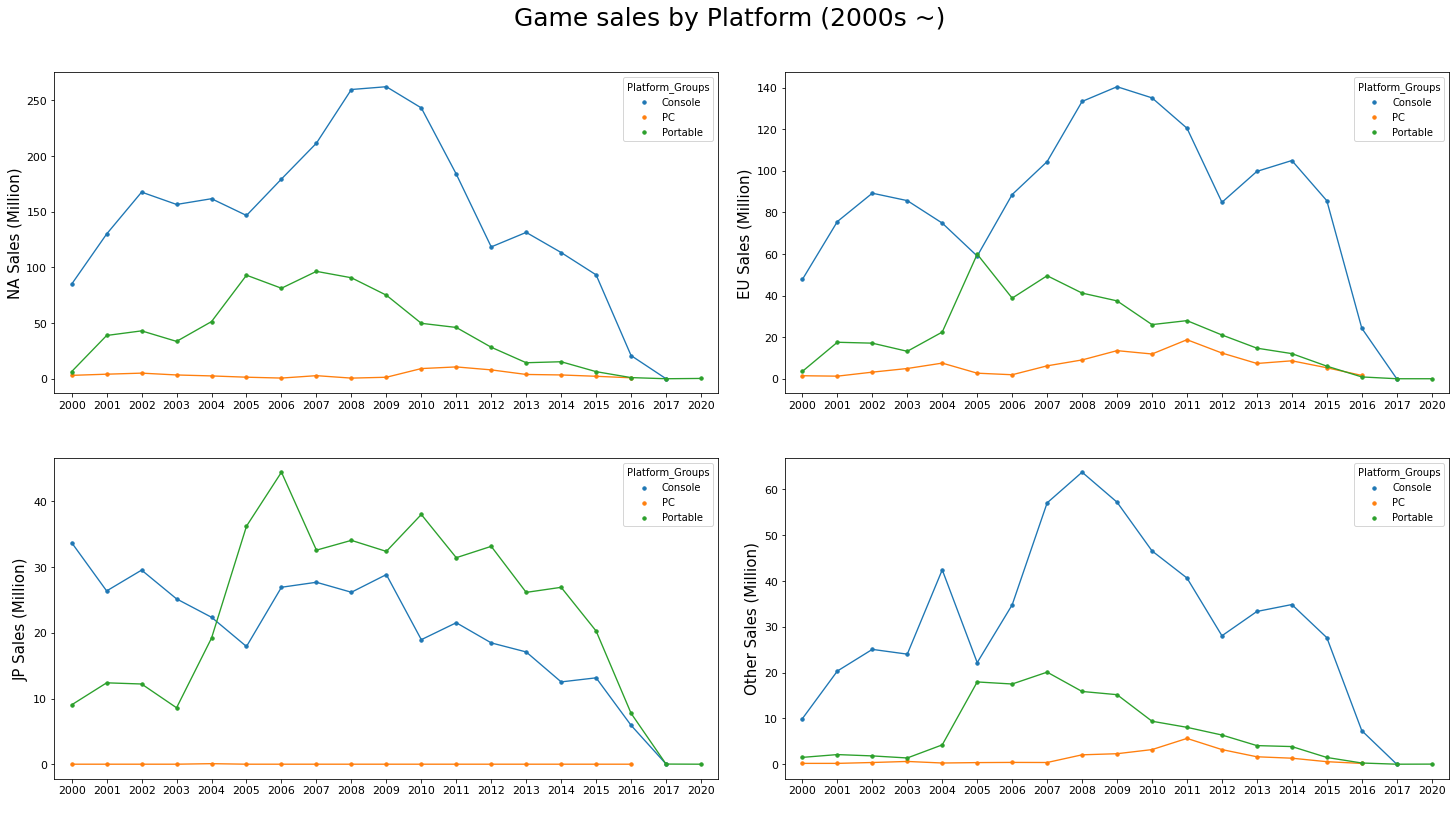

In [59]:
fig , ax = plt.subplots(2,2, figsize=(25,13))
sns.pointplot(x='Year', y='NA_Sales', hue='Platform_Groups', scale = .5, data=subset_year_platform, ax=ax[0,0])
ax[0,0].set_ylabel('NA Sales (Million)', fontsize=15)
ax[0,0].set_xlabel(' ')
ax[0,0].tick_params(labelsize=11)

sns.pointplot(x='Year', y='EU_Sales', hue='Platform_Groups', scale = .5, data=subset_year_platform, ax=ax[0,1])
ax[0,1].set_ylabel('EU Sales (Million)', fontsize=15)
ax[0,1].set_xlabel(' ')
ax[0,1].tick_params(labelsize=11)

sns.pointplot(x='Year', y='JP_Sales', hue='Platform_Groups', scale = .5, data=subset_year_platform, ax=ax[1,0])
ax[1,0].set_ylabel('JP Sales (Million)', fontsize=15)
ax[1,0].set_xlabel(' ')
ax[1,0].tick_params(labelsize=11)

sns.pointplot(x='Year', y='Other_Sales', hue='Platform_Groups', scale = .5, data=subset_year_platform, ax=ax[1,1])
ax[1,1].set_ylabel('Other Sales (Million)', fontsize=15)
ax[1,1].set_xlabel(' ')
ax[1,1].tick_params(labelsize=11)

fig.suptitle('Game sales by Platform (2000s ~)', fontsize=25, y=0.95)
plt.subplots_adjust(hspace=0.2, wspace = 0.1)

plt.show()

- 북미, 유럽, 그외 지역은 콘솔 게임이 게임 시장의 대부분을 차지하나, 일본지역은 휴대용 기기 게임이 콘솔 게임을 앞선다.
- 일본 지역을 타겟으로하여 게임을 출시할 경우, 휴대용 기기를 염두하여 출시할 필요가 있다.

In [60]:
df[df['Year']>=2000].head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Platform_Groups,Multiplatform
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04,Portable,1
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18,Console,0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02,Portable,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04,Portable,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25,Console,1


In [61]:
subset_year_multiplatform = df[df['Year']>=2000].groupby(['Year', 'Multiplatform']).sum()
subset_year_multiplatform.head()

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Total_Sales
Year Multiplatform                                                        
2000 0                 59.95     34.90     33.60         8.02       136.47
     1                 34.47     17.83      9.17         3.60        65.07
2001 0                 98.25     55.39     33.09        12.30       199.03
     1                 74.61     38.97      5.68        10.32       129.58
2002 0                 92.91     45.42     33.62         9.72       181.67

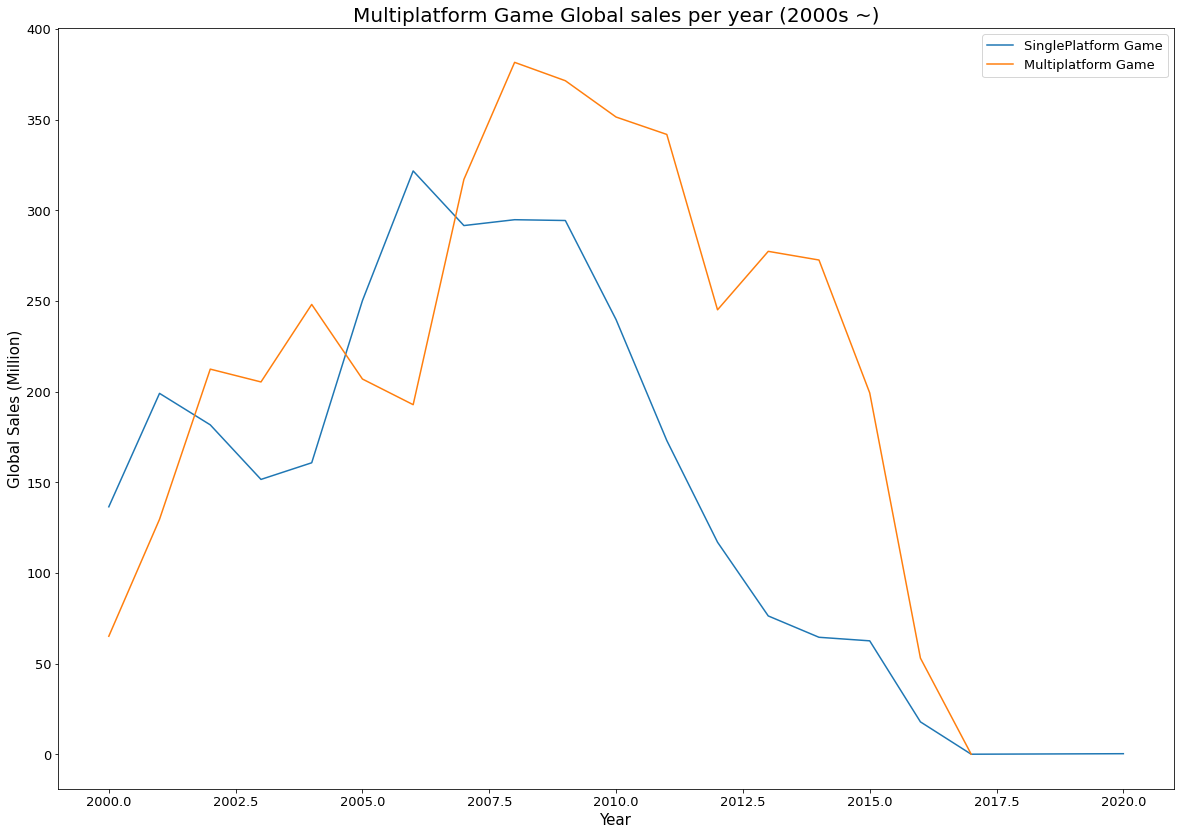

In [62]:
plt.figure(figsize = (20,14))
ax = plt.gca()
sns.lineplot(x='Year', y='Total_Sales', data=subset_year_multiplatform, hue='Multiplatform')
ax.tick_params(labelsize=13)

plt.legend(loc='best',labels = ['SinglePlatform Game', 'Multiplatform Game'], fontsize = 13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Global Sales (Million)', fontsize = 15)
plt.title('Multiplatform Game Global sales per year (2000s ~)', fontsize = 20)

plt.show()

- 2000년대 초반에는 잠깐 싱글 플랫폼 게임의 판매량이 높게 나타났지만, 2007년 이후로는 멀티 플랫폼 게임의 판매량이 높게 나타났다.

In [63]:
subset_year_platgroup_multiplatform = df[df['Year']>=2000].groupby(by=["Year",'Platform_Groups','Multiplatform']).sum() #2000년대 이후 출시게임
subset_year_platgroup_multiplatform = subset_year_platgroup_multiplatform.reset_index()

subset_year_platgroup_multiplatform.head(20)

,Year,Platform_Groups,Multiplatform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,2000,Console,0,52.93,31.23,26.70,6.60,117.46
1,2000,Console,1,32.02,16.52,7.03,3.35,58.92
2,2000,PC,0,3.02,1.41,0.00,0.17,4.60
3,2000,PC,1,0.01,0.03,0.00,0.01,0.05
4,2000,Portable,0,4.00,2.26,6.90,1.25,14.41
5,2000,Portable,1,2.44,1.28,2.14,0.24,6.10
6,2001,Console,0,68.80,42.85,23.72,10.68,146.05
7,2001,Console,1,61.14,32.73,2.66,9.66,106.19
8,2001,PC,0,4.07,1.17,0.00,0.17,5.41
9,2001,PC,1,0.01,0.07,0.00,0.01,0.09


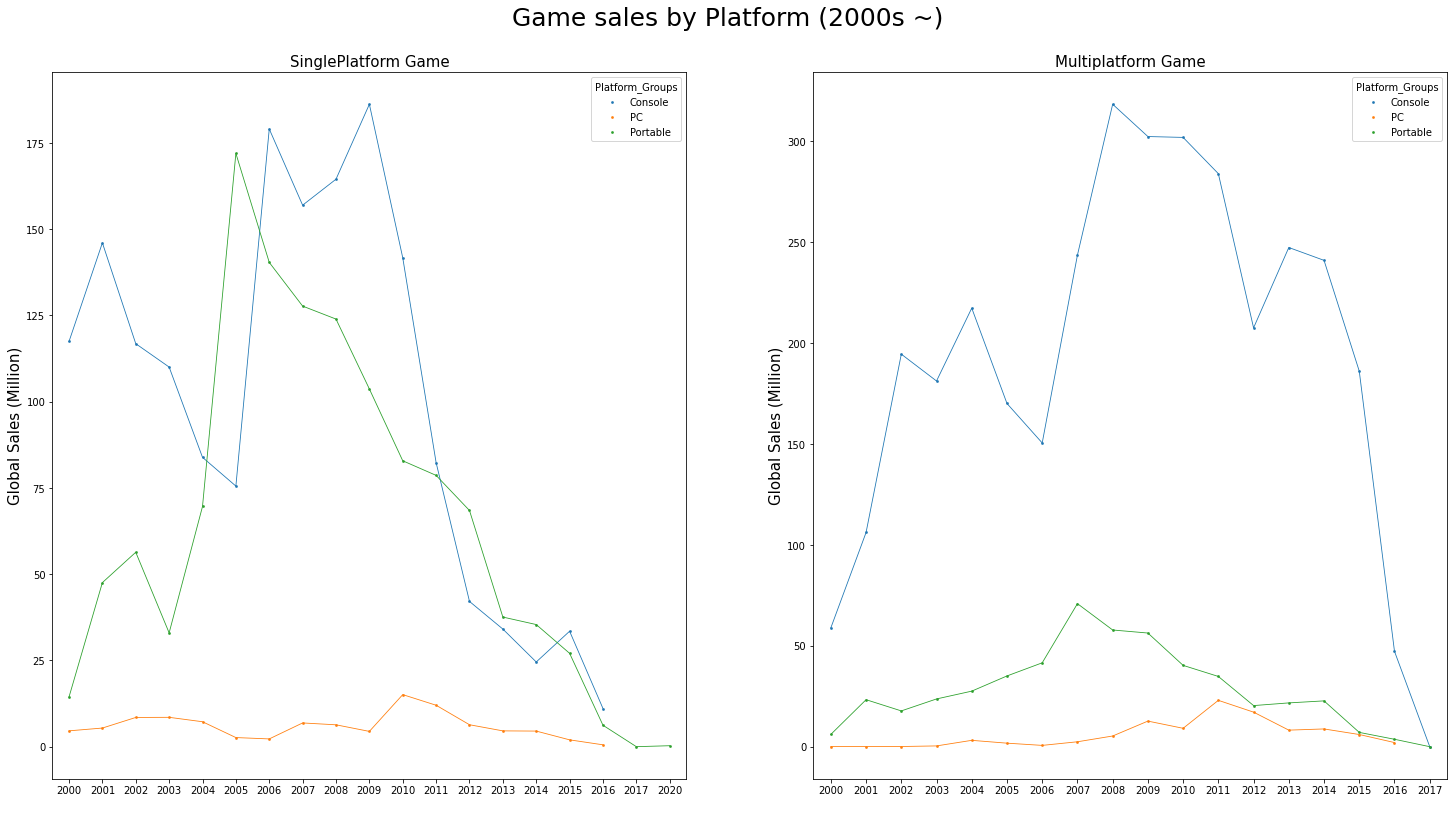

In [64]:
fig , ax = plt.subplots(1,2, figsize=(25,13))
sns.pointplot(x='Year', y='Total_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==0], ax=ax[0])
ax[0].set_xlabel(' ')
ax[0].set_ylabel('Global Sales (Million)', fontsize = 15)
ax[0].set_title('SinglePlatform Game', fontsize = 15)
ax[0].tick_params(labelsize=10)

sns.pointplot(x='Year', y='Total_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==1], ax=ax[1])
ax[1].set_xlabel(' ')
ax[1].set_ylabel('Global Sales (Million)', fontsize = 15)
ax[1].set_title('Multiplatform Game', fontsize = 15)
ax[1].tick_params(labelsize=10)

fig.suptitle('Game sales by Platform (2000s ~)', fontsize=25, y=0.95)

plt.show()

- 싱글 플랫폼 게임의 경우, 2000 ~ 2004년도까지는 콘솔 게임의 판매량이 많았지만,
그 이후부터는 콘솔게임과 휴대용 기기게임의 판매량이 비슷하게 나타났다.
- 멀티 플랫폼 게임의 경우, 전체적으로 콘솔 게임의 판매량이 압도적으로 높다.
  > 휴대용 기기 게임의 출시를 염두하고 있다면, 싱글 플랫폼으로 출시하는 편이 매출에 도움이 될 수 있다.
  > 반대로 콘솔 게임의 출시를 염두하고 있다면, 멀티 플랫폼으로 출시하는 편이 매출에 도움이 될 수 있다.

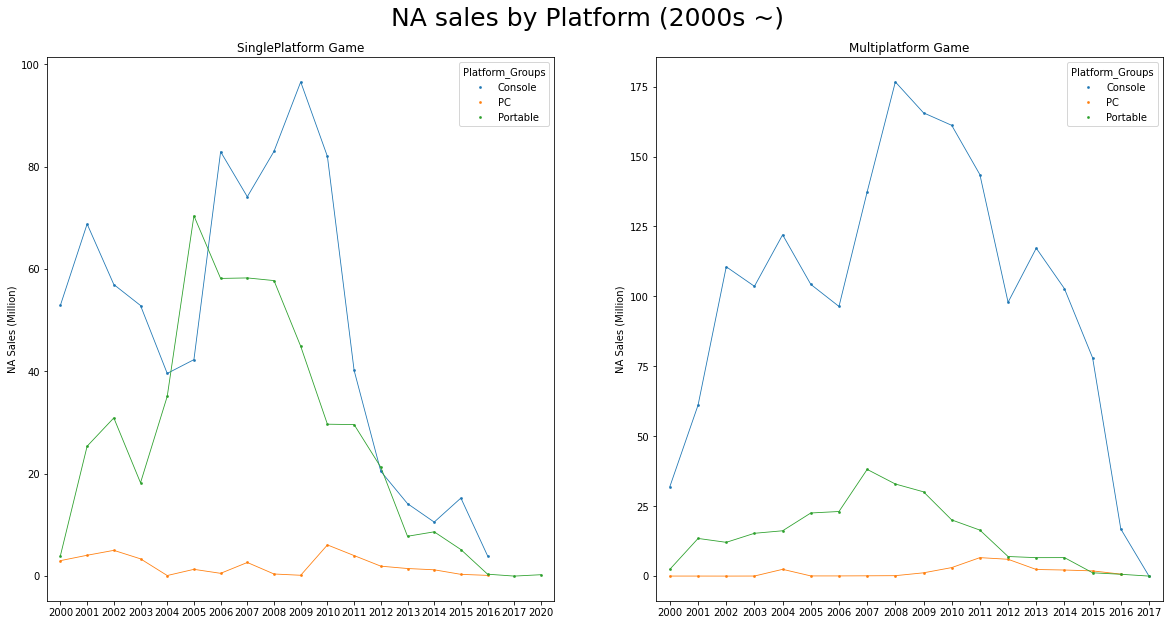

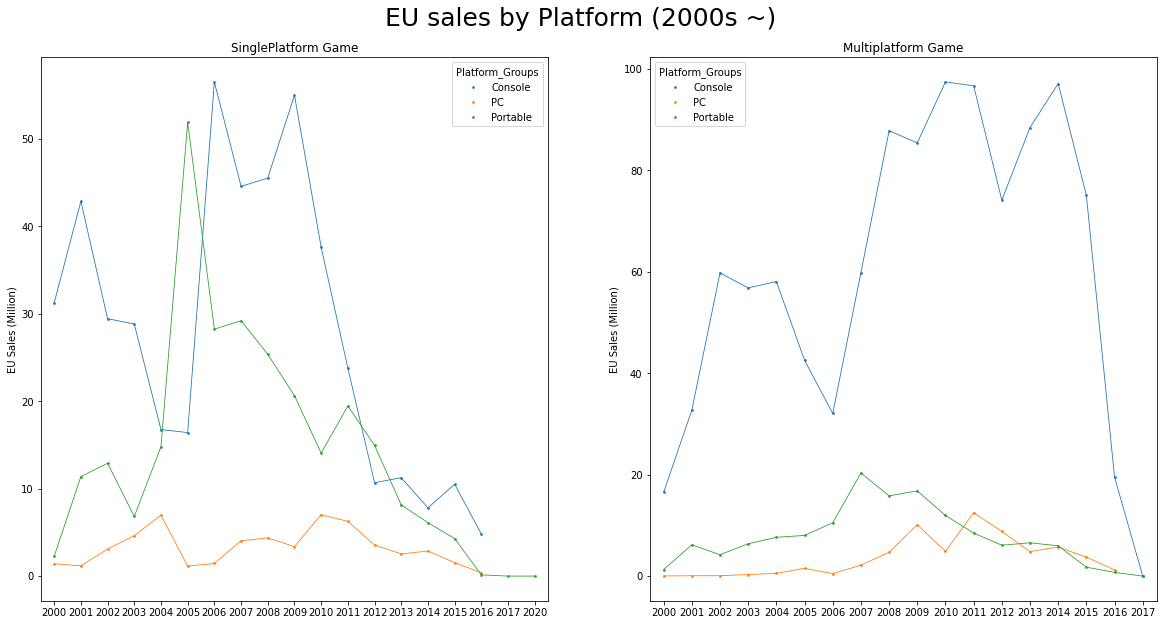

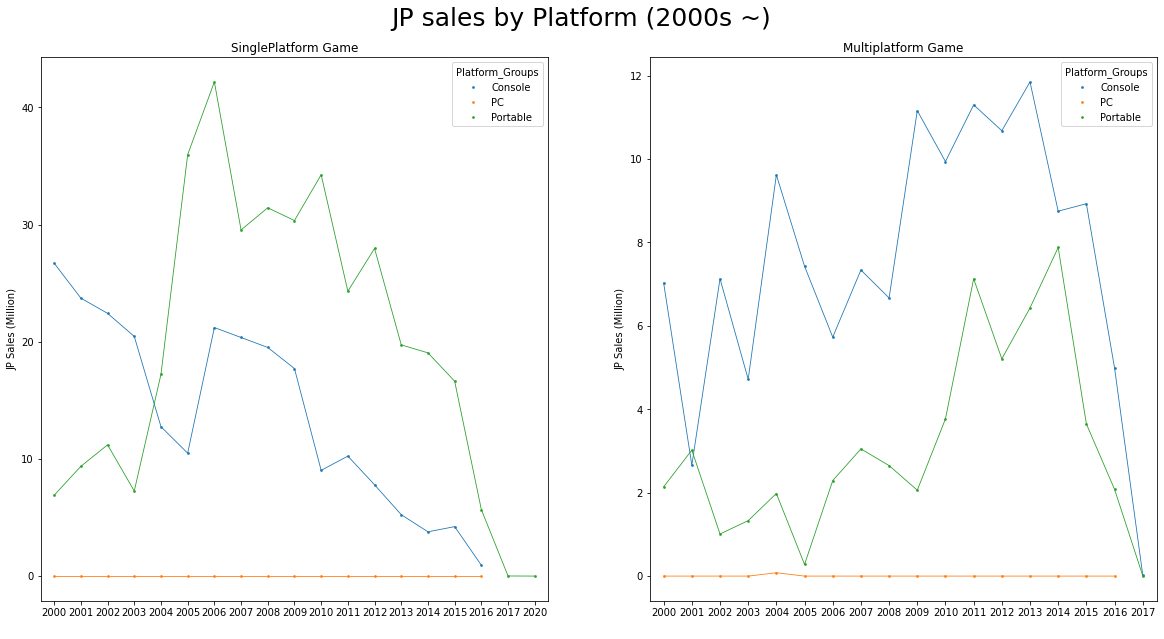

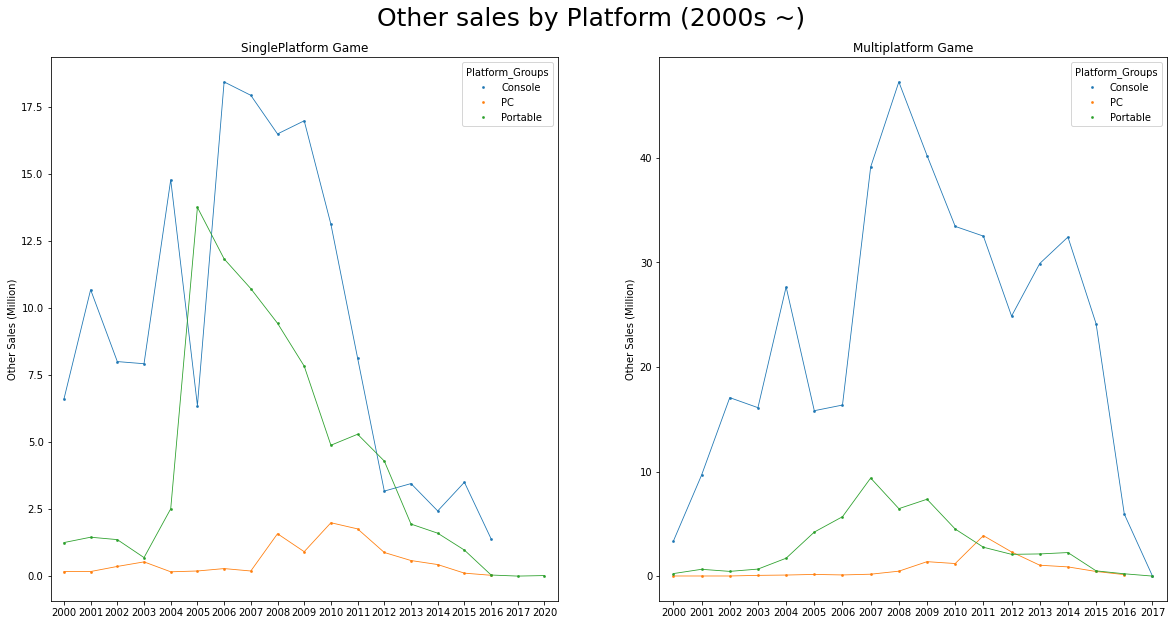

In [65]:
# 북미지역 판매량
fig , ax = plt.subplots(1,2, figsize=(20,10))
sns.pointplot(x='Year', y='NA_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==0], ax=ax[0])
ax[0].set_xlabel(' ')
ax[0].set_ylabel('NA Sales (Million)', fontsize = 10)
ax[0].set_title('SinglePlatform Game')

sns.pointplot(x='Year', y='NA_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==1], ax=ax[1])
ax[1].set_xlabel(' ')
ax[1].set_ylabel('NA Sales (Million)', fontsize = 10)
ax[1].set_title('Multiplatform Game')

fig.suptitle('NA sales by Platform (2000s ~)', fontsize=25, y=0.95)
plt.show()

# 유럽지역 판매량
fig , ax = plt.subplots(1,2, figsize=(20,10))
sns.pointplot(x='Year', y='EU_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==0], ax=ax[0])
ax[0].set_xlabel(' ')
ax[0].set_ylabel('EU Sales (Million)', fontsize = 10)
ax[0].set_title('SinglePlatform Game')

sns.pointplot(x='Year', y='EU_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==1], ax=ax[1])
ax[1].set_xlabel(' ')
ax[1].set_ylabel('EU Sales (Million)', fontsize = 10)
ax[1].set_title('Multiplatform Game')

fig.suptitle('EU sales by Platform (2000s ~)', fontsize=25, y=0.95)
plt.show()

# 일본지역 판매량
fig , ax = plt.subplots(1,2, figsize=(20,10))
sns.pointplot(x='Year', y='JP_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==0], ax=ax[0])
ax[0].set_xlabel(' ')
ax[0].set_ylabel('JP Sales (Million)', fontsize = 10)
ax[0].set_title('SinglePlatform Game')

sns.pointplot(x='Year', y='JP_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==1], ax=ax[1])
ax[1].set_xlabel(' ')
ax[1].set_ylabel('JP Sales (Million)', fontsize = 10)
ax[1].set_title('Multiplatform Game')

fig.suptitle('JP sales by Platform (2000s ~)', fontsize=25, y=0.95)
plt.show()

# 그외지역 판매량
fig , ax = plt.subplots(1,2, figsize=(20,10))
sns.pointplot(x='Year', y='Other_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==0], ax=ax[0])
ax[0].set_xlabel(' ')
ax[0].set_ylabel('Other Sales (Million)', fontsize = 10)
ax[0].set_title('SinglePlatform Game')

sns.pointplot(x='Year', y='Other_Sales', hue='Platform_Groups', scale = .3, data=subset_year_platgroup_multiplatform[subset_year_platgroup_multiplatform['Multiplatform']==1], ax=ax[1])
ax[1].set_xlabel(' ')
ax[1].set_ylabel('Other Sales (Million)', fontsize = 10)
ax[1].set_title('Multiplatform Game')

fig.suptitle('Other sales by Platform (2000s ~)', fontsize=25, y=0.95)
plt.show()

- 일본을 제외한 북미, 유럽, 그 외지역의 경우, 싱글플랫폼 게임은 콘솔게임의 판매량이 대체적으로 높다.
- 일본의 경우 싱글플랫폼 게임은 휴대용 기기 게임의 판매량이 콘솔게임 판매량 보다 높다.
- 멀티 플랫폼 게임의 경우, 모든 지역에서 콘솔 게임의 판매량이 압도적으로 많다.

### 6. Genre, Year

In [66]:
# 2000년대 이후 전 지역 연간 인기 게임 장르에 대한 판매량
year_list = []
best_genre_list = []
sale_list = []

subset_year_genre =  df[df['Year']>=2000].groupby(['Year','Genre']).sum()['Total_Sales'].reset_index()

for i in range(2000, 2018) :
    year_genre = subset_year_genre[subset_year_genre['Year'] == i].sort_values(by='Total_Sales',ascending=False).reset_index(drop=True)

    best_genre = year_genre.loc[0, 'Genre']
    best_genre_sale =  year_genre.loc[0, 'Total_Sales']

    year_list.append(i)
    best_genre_list.append(best_genre)
    sale_list.append(best_genre_sale)
    
df_year_best_genre_sale = pd.DataFrame((zip(year_list, best_genre_list, sale_list)), columns = ['Year', 'Best_Genre', 'Total_Sales'])
df_year_best_genre_sale

,Year,Best_Genre,Total_Sales
0,2000,Sports,41.24
1,2001,Action,56.68
2,2002,Action,86.65
3,2003,Action,67.98
4,2004,Action,76.15
5,2005,Action,85.52
6,2006,Sports,136.12
7,2007,Action,105.99
8,2008,Action,135.46
9,2009,Sports,138.59


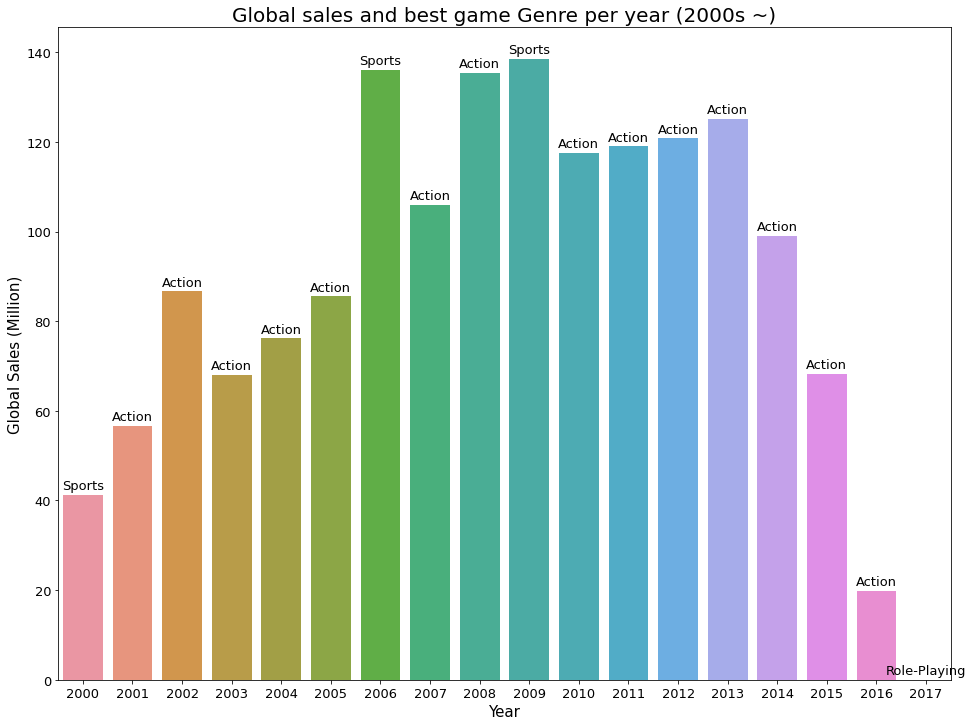

In [67]:
fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='Total_Sales', data=df_year_best_genre_sale)

# for idx, value in df_year_best_genre_sale.iterrows():
#     fig.text(value['Year'], (value['Total_Sales'])/2, str(value['Genre']), size=15,rotation=90)

for index, row in df_year_best_genre_sale.iterrows():
    plt.text(index , row.Total_Sales + 2, str(row.Best_Genre), color='black', va='center', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Global Sales (Million)', fontsize = 15)
plt.title('Global sales and best game Genre per year (2000s ~)', fontsize = 20)

plt.show()

- 전체 지역의 년도별 가장 많은 판매량을 기록한 장르는 대부분 Action 이다.
- 2000, 2006, 2009년도 에서는 Sports 장르가 가장 많은 판매량을 기록 했다.
- 2017년도에는 수집한 데이터가 적어서 정확한 분석을 하기 어렵지만 가장 많은 판매량을 기록한 장르는 Role-Playing 이다.

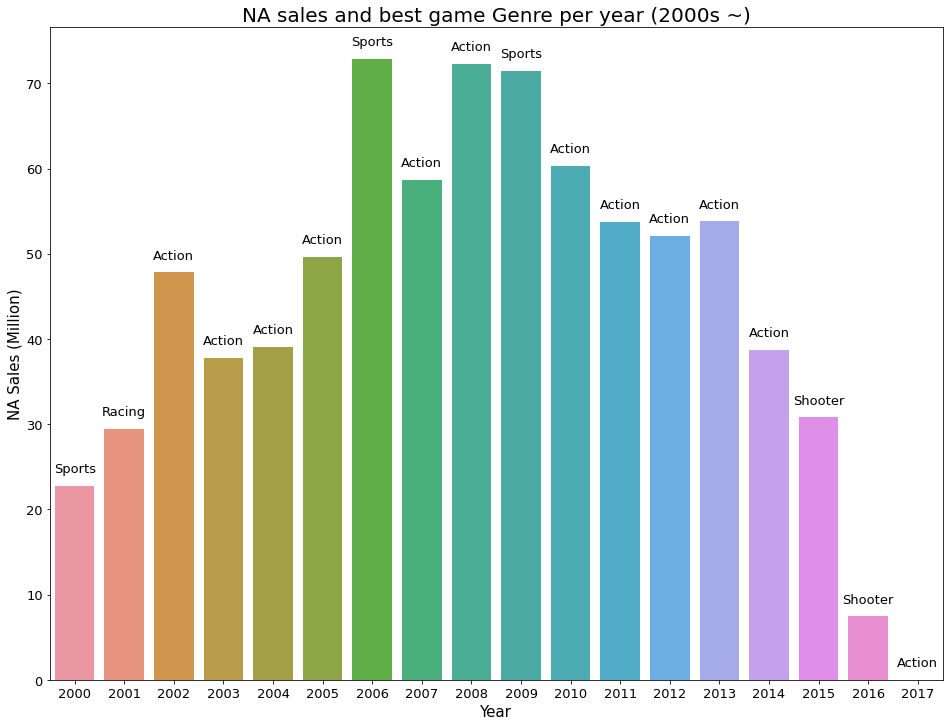

In [68]:
# 북미 지역
year_list = []
best_genre_list = []
sale_list = []

subset_year_genre_NA =  df[df['Year']>=2000].groupby(['Year','Genre']).sum()['NA_Sales'].reset_index()

for i in range(2000, 2018) :
    year_genre = subset_year_genre_NA[subset_year_genre_NA['Year'] == i].sort_values(by='NA_Sales',ascending=False).reset_index(drop=True)

    best_genre = year_genre.loc[0, 'Genre']
    best_genre_sale =  year_genre.loc[0, 'NA_Sales']

    year_list.append(i)
    best_genre_list.append(best_genre)
    sale_list.append(best_genre_sale)
    
df_year_best_genre_sale = pd.DataFrame((zip(year_list, best_genre_list, sale_list)), columns = ['Year', 'Best_Genre', 'NA_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='NA_Sales', data=df_year_best_genre_sale)

for index, row in df_year_best_genre_sale.iterrows():
    plt.text(index , row.NA_Sales + 2, str(row.Best_Genre), color='black', va='center', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('NA Sales (Million)', fontsize = 15)
plt.title('NA sales and best game Genre per year (2000s ~)', fontsize = 20)

plt.show()

- 전체 지역의 년도별 가장 많은 판매량을 기록한 장르는 대부분 Action 이다.
- 2000, 2006, 2009년도에서는 Sports 장르가 가장 많은 판매량을 기록 했다.
- 2001년도에는 Racing 장르가 가장 많은 판매량을 기록 했다.
- 2015, 2016년도에는 Shooter 장르가 가장 많은 판매량을 기록 했다.
- 2017년도에는 수집한 데이터가 적어서 정확한 분석을 하기 어렵지만 가장 많은 판매량을 기록한 장르는 Action 이다.

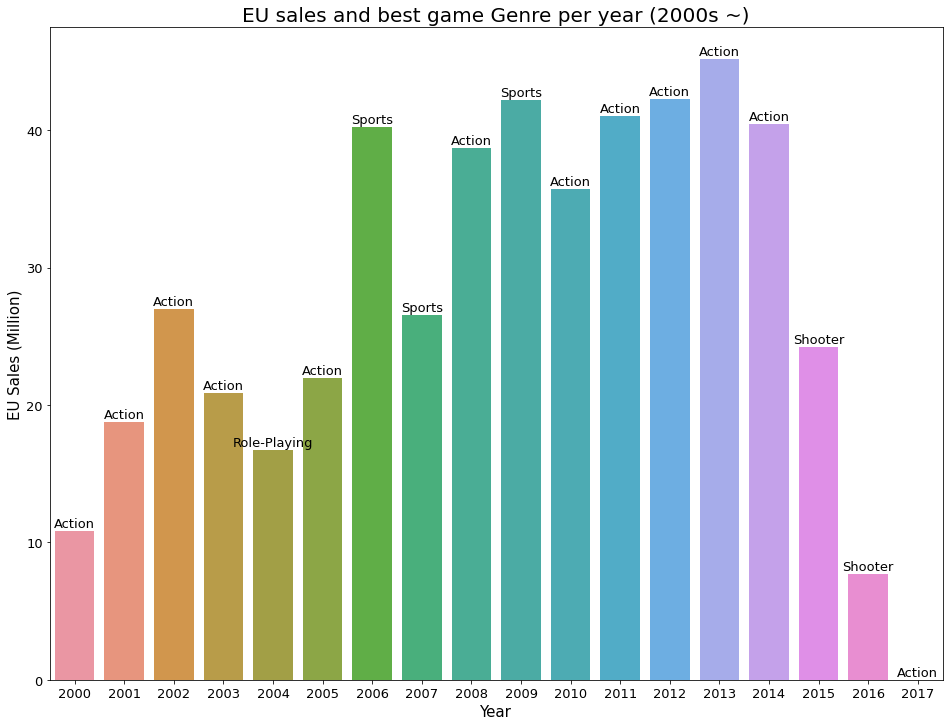

In [69]:
# 유럽 지역
year_list = []
best_genre_list = []
sale_list = []

subset_year_genre_NA =  df[df['Year']>=2000].groupby(['Year','Genre']).sum()['EU_Sales'].reset_index()

for i in range(2000, 2018) :
    year_genre = subset_year_genre_NA[subset_year_genre_NA['Year'] == i].sort_values(by='EU_Sales',ascending=False).reset_index(drop=True)

    best_genre = year_genre.loc[0, 'Genre']
    best_genre_sale =  year_genre.loc[0, 'EU_Sales']

    year_list.append(i)
    best_genre_list.append(best_genre)
    sale_list.append(best_genre_sale)
    
df_year_best_genre_sale = pd.DataFrame((zip(year_list, best_genre_list, sale_list)), columns = ['Year', 'Best_Genre', 'EU_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='EU_Sales', data=df_year_best_genre_sale)

for index, row in df_year_best_genre_sale.iterrows():
    plt.text(index , row.EU_Sales + 1, str(row.Best_Genre), color='black', va='top', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('EU Sales (Million)', fontsize = 15)
plt.title('EU sales and best game Genre per year (2000s ~)', fontsize = 20)

plt.show()

- 2004년도에는 Role-Playing 장르가 가장 많은 판매량을 기록했다.
- 2006, 2007, 2009년도에는 Sports 장르가 가장 많은 판매량을 기록했다.
- 2015, 2016년도에는 Shooter 장르가 가장 많은 판매량을 기록했다.
- 2017년도에는 수집한 데이터가 적어서 정확한 분석을 하기 어렵지만 가장 많은 판매량을 기록한 장르는 Action 이다.

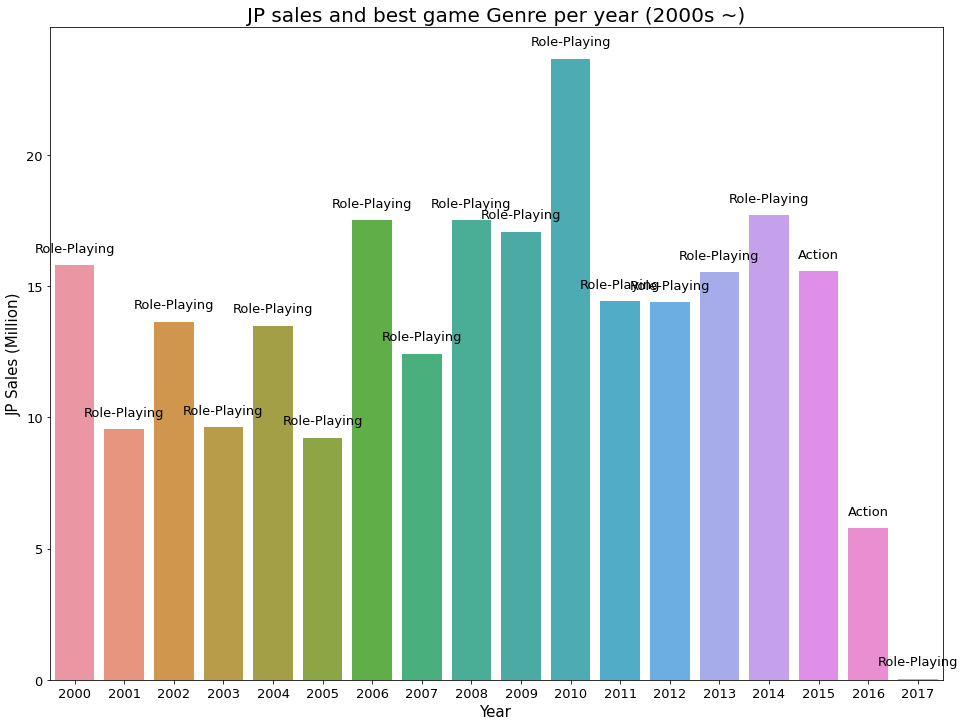

In [70]:
# 일본 지역
year_list = []
best_genre_list = []
sale_list = []

subset_year_genre_NA =  df[df['Year']>=2000].groupby(['Year','Genre']).sum()['JP_Sales'].reset_index()

for i in range(2000, 2018) :
    year_genre = subset_year_genre_NA[subset_year_genre_NA['Year'] == i].sort_values(by='JP_Sales',ascending=False).reset_index(drop=True)

    best_genre = year_genre.loc[0, 'Genre']
    best_genre_sale =  year_genre.loc[0, 'JP_Sales']

    year_list.append(i)
    best_genre_list.append(best_genre)
    sale_list.append(best_genre_sale)
    
df_year_best_genre_sale = pd.DataFrame((zip(year_list, best_genre_list, sale_list)), columns = ['Year', 'Best_Genre', 'JP_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='JP_Sales', data=df_year_best_genre_sale)

for index, row in df_year_best_genre_sale.iterrows():
    plt.text(index , row.JP_Sales + 0.5, str(row.Best_Genre), color='black', va='baseline', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('JP Sales (Million)', fontsize = 15)
plt.title('JP sales and best game Genre per year (2000s ~)', fontsize = 20)

plt.show()

- 2000 ~ 2014년도에는 Role-Playing 장르의 매출이 높았다.
- 2015 ~ 2016년도에는 Action 장르의 매출이 높았다.
- 2017년도에는 수집한 데이터가 적어서 정확한 분석을 하기 어렵지만 가장 많은 판매량을 기록한 장르는 Role-Playing 이다.

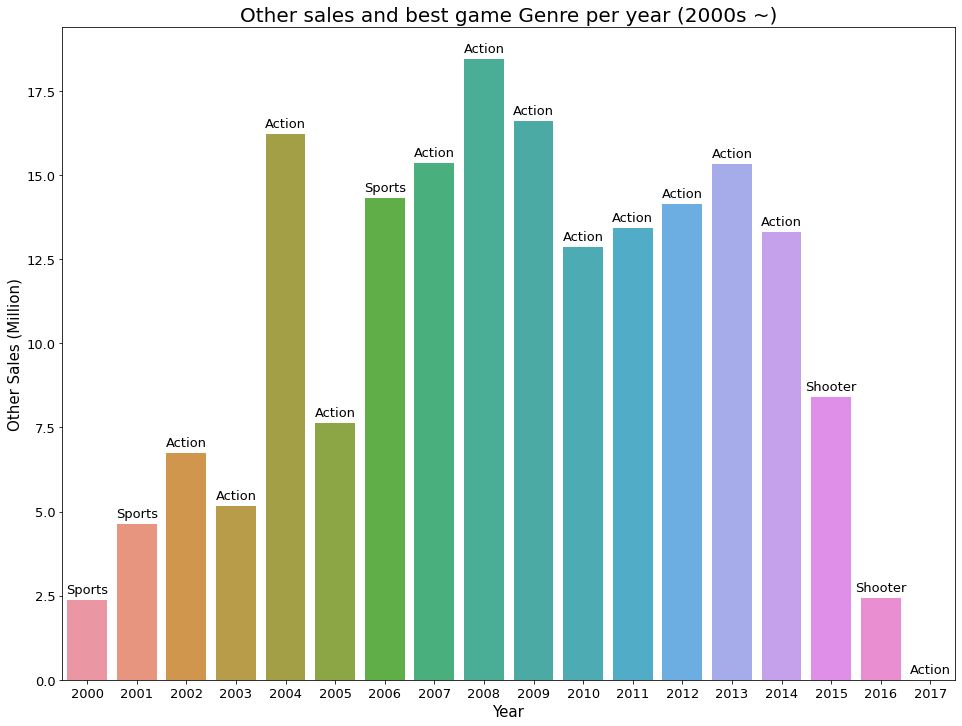

In [71]:
# 그 외지역
year_list = []
best_genre_list = []
sale_list = []

subset_year_genre_NA =  df[df['Year']>=2000].groupby(['Year','Genre']).sum()['Other_Sales'].reset_index()

for i in range(2000, 2018) :
    year_genre = subset_year_genre_NA[subset_year_genre_NA['Year'] == i].sort_values(by='Other_Sales',ascending=False).reset_index(drop=True)

    best_genre = year_genre.loc[0, 'Genre']
    best_genre_sale =  year_genre.loc[0, 'Other_Sales']

    year_list.append(i)
    best_genre_list.append(best_genre)
    sale_list.append(best_genre_sale)
    
df_year_best_genre_sale = pd.DataFrame((zip(year_list, best_genre_list, sale_list)), columns = ['Year', 'Best_Genre', 'Other_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='Other_Sales', data=df_year_best_genre_sale)

for index, row in df_year_best_genre_sale.iterrows():
    plt.text(index , row.Other_Sales + 0.2, str(row.Best_Genre), color='black', va='baseline', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Other Sales (Million)', fontsize = 15)
plt.title('Other sales and best game Genre per year (2000s ~)', fontsize = 20)

plt.show()

- 2022 ~ 2014년도 까지는 2006년도를 제외하고 Action 장르의 매출이 가장 높았다.
- 2000, 2001, 2006년도에는 Sports 장르의 매출이 가장 높았다.
- 2015, 2016년도에는 Shooter 장르의 매출이 가장 높았다.
- 2017년도에는 **수집한** 데이터가 적어서 정확한 분석을 하기 어렵지만 Action 장르의 매출이 가장 높았다.

### 7. Publisher, Year

In [72]:
# 전지역
year_list = []
best_pub_list = []
sale_list = []

subset_year_pub =  df[df['Year']>=2000].groupby(['Year','Publisher']).sum()['Total_Sales'].reset_index()

for i in range(2000, 2018) :
    year_pub = subset_year_pub[subset_year_pub['Year'] == i].sort_values(by='Total_Sales',ascending=False).reset_index(drop=True)

    best_pub = year_pub.loc[0, 'Publisher']
    best_pub_sale =  year_pub.loc[0, 'Total_Sales']

    year_list.append(i)
    best_pub_list.append(best_pub)
    sale_list.append(best_pub_sale)
    
year_pub = pd.DataFrame((zip(year_list, best_pub_list, sale_list)), columns = ['Year', 'Best_Publisher', 'Total_Sales'])
year_pub

,Year,Best_Publisher,Total_Sales
0,2000,Nintendo,34.02
1,2001,Nintendo,45.41
2,2002,Electronic Arts,72.27
3,2003,Electronic Arts,69.78
4,2004,Electronic Arts,62.98
5,2005,Nintendo,127.37
6,2006,Nintendo,205.60
7,2007,Nintendo,104.16
8,2008,Nintendo,91.14
9,2009,Nintendo,128.86


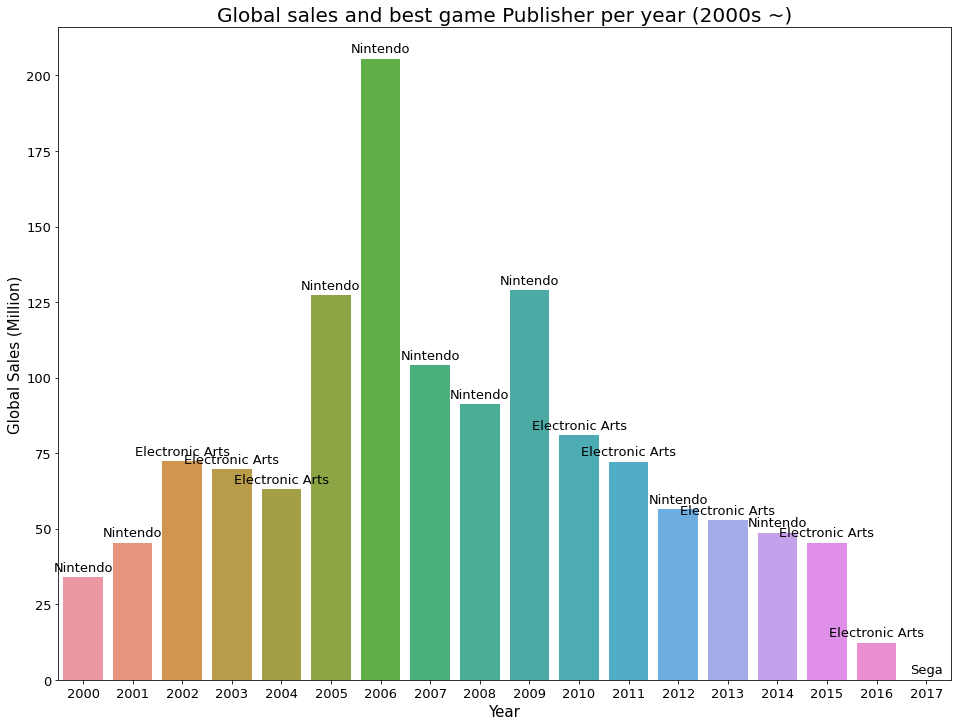

In [73]:
fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='Total_Sales', data=year_pub)

for index, row in year_pub.iterrows():
    plt.text(index , row.Total_Sales + 2, str(row.Best_Publisher), color='black', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Global Sales (Million)', fontsize = 15)
plt.title('Global sales and best game Publisher per year (2000s ~)', fontsize = 20)
plt.show()

- 2000 ~ 2016년도 까지 Nintendo 와 Electronic Arts 의 판매량이 높았다.
- 2017년도 데이터는 수집한 양이 적기 때문에 통계량이 정확하지 않을것으로 보인다.

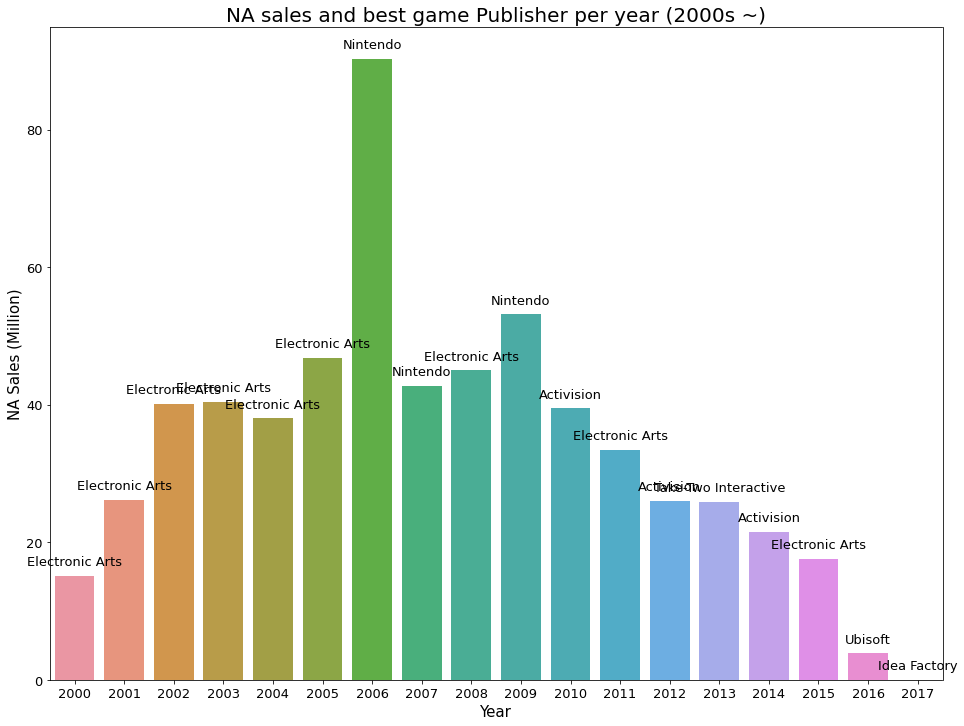

In [74]:
# 북미 지역
year_list = []
best_pub_list = []
sale_list = []

subset_year_pub =  df[df['Year']>=2000].groupby(['Year','Publisher']).sum()['NA_Sales'].reset_index()

for i in range(2000, 2018) :
    year_pub = subset_year_pub[subset_year_pub['Year'] == i].sort_values(by='NA_Sales',ascending=False).reset_index(drop=True)

    best_pub = year_pub.loc[0, 'Publisher']
    best_pub_sale =  year_pub.loc[0, 'NA_Sales']

    year_list.append(i)
    best_pub_list.append(best_pub)
    sale_list.append(best_pub_sale)
    
year_pub = pd.DataFrame((zip(year_list, best_pub_list, sale_list)), columns = ['Year', 'Best_Publisher', 'NA_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='NA_Sales', data=year_pub)

for index, row in year_pub.iterrows():
    plt.text(index , row.NA_Sales + 1.5, str(row.Best_Publisher), color='black', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('NA Sales (Million)', fontsize = 15)
plt.title('NA sales and best game Publisher per year (2000s ~)', fontsize = 20)
plt.show()

- 전지역을 대상으로 게임 회사의 판매량을 조사 했을 때는 없었던 Activision, Take-Two, Ubisoft 등의 회사가 매출이 제일 높았던 적이 있다.
- 2017년도 데이터는 수집한 양이 적기 때문에 통계량이 정확하지 않을것으로 보인다.

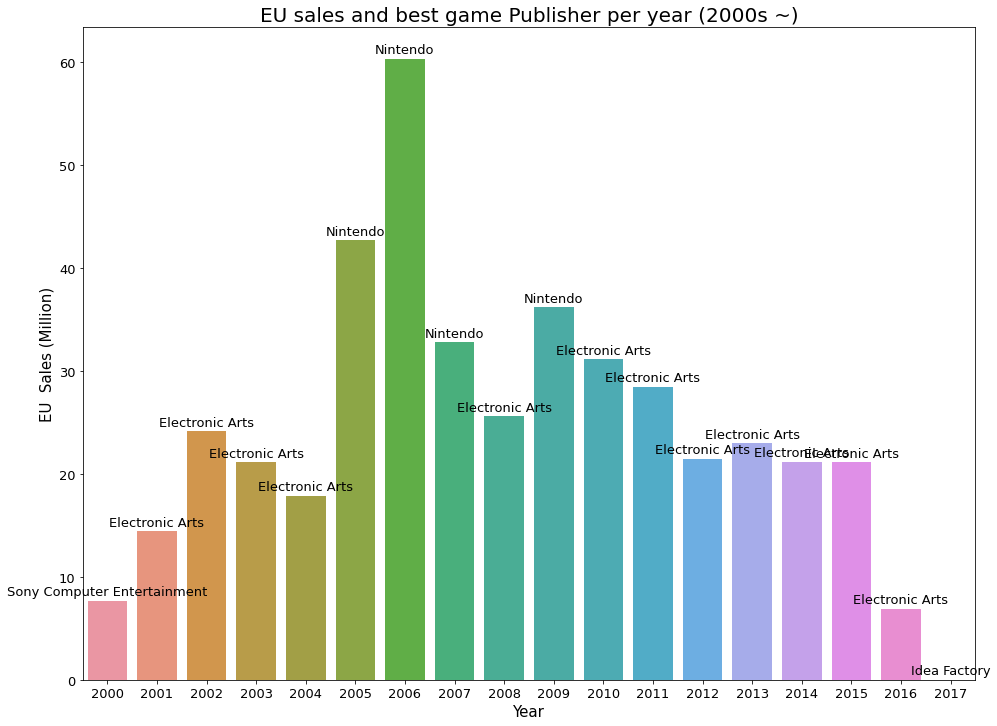

In [75]:
# 유럽 지역
year_list = []
best_pub_list = []
sale_list = []

subset_year_pub =  df[df['Year']>=2000].groupby(['Year','Publisher']).sum()['EU_Sales'].reset_index()

for i in range(2000, 2018) :
    year_pub = subset_year_pub[subset_year_pub['Year'] == i].sort_values(by='EU_Sales',ascending=False).reset_index(drop=True)

    best_pub = year_pub.loc[0, 'Publisher']
    best_pub_sale =  year_pub.loc[0, 'EU_Sales']

    year_list.append(i)
    best_pub_list.append(best_pub)
    sale_list.append(best_pub_sale)
    
year_pub = pd.DataFrame((zip(year_list, best_pub_list, sale_list)), columns = ['Year', 'Best_Publisher', 'EU_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='EU_Sales', data=year_pub)

for index, row in year_pub.iterrows():
    plt.text(index , row.EU_Sales + 0.5, str(row.Best_Publisher), color='black', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('EU  Sales (Million)', fontsize = 15)
plt.title('EU sales and best game Publisher per year (2000s ~)', fontsize = 20)
plt.show()

- 2005 ~ 2007년도에는 Nintendo 가 매출이 제일 높았지만, 2000년도를 제외한 나머지 년도는 Electronic Arts 가 매출이 가장 높았다.
- 2017년도 데이터는 수집한 양이 적기 때문에 통계량이 정확하지 않을것으로 보인다.

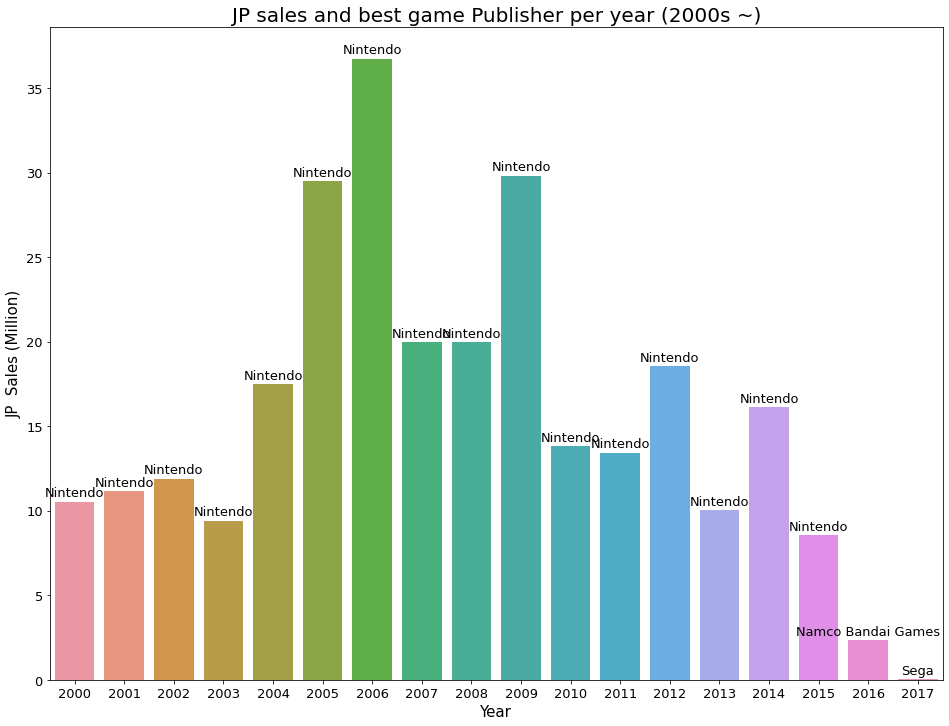

In [76]:
# 일본 지역
year_list = []
best_pub_list = []
sale_list = []

subset_year_pub =  df[df['Year']>=2000].groupby(['Year','Publisher']).sum()['JP_Sales'].reset_index()

for i in range(2000, 2018) :
    year_pub = subset_year_pub[subset_year_pub['Year'] == i].sort_values(by='JP_Sales',ascending=False).reset_index(drop=True)

    best_pub = year_pub.loc[0, 'Publisher']
    best_pub_sale =  year_pub.loc[0, 'JP_Sales']

    year_list.append(i)
    best_pub_list.append(best_pub)
    sale_list.append(best_pub_sale)
    
year_pub = pd.DataFrame((zip(year_list, best_pub_list, sale_list)), columns = ['Year', 'Best_Publisher', 'JP_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='JP_Sales', data=year_pub)

for index, row in year_pub.iterrows():
    plt.text(index , row.JP_Sales + 0.3, str(row.Best_Publisher), color='black', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('JP  Sales (Million)', fontsize = 15)
plt.title('JP sales and best game Publisher per year (2000s ~)', fontsize = 20)
plt.show()

- 2016년도를 제외한 모든 년도에서 Nintendo 가 매출이 가장 높았다.
- 2016년도에는 Namco Bandai Games 가 매출이 가장 높았다.
- 일본 지역에서는 휴대용 기기 게임의 판매량이 높았었는데 위 그래프를 보면 알다시피 휴대용 기기 게임을 많이 판매하는 게임 회사 Namco Bandai Games, Nintendo의 판매량이 높았던것과 연관성이 높다는 것을 알 수 있다.
- 2017년도 데이터는 수집한 양이 적기 때문에 통계량이 정확하지 않을것으로 보인다.

In [77]:
df[(df['Year']>=2000) & (df['Platform_Groups'] == 'Portable')]['Publisher'].value_counts()

# (df['Year']>=2000)

Namco Bandai Games              404
Nintendo                        332
Ubisoft                         302
Konami Digital Entertainment    276
THQ                             256
                               ... 
Marvel Entertainment              1
Sammy Corporation                 1
Media Rings                       1
The Adventure Company             1
Reef Entertainment                1
Name: Publisher, Length: 294, dtype: int64

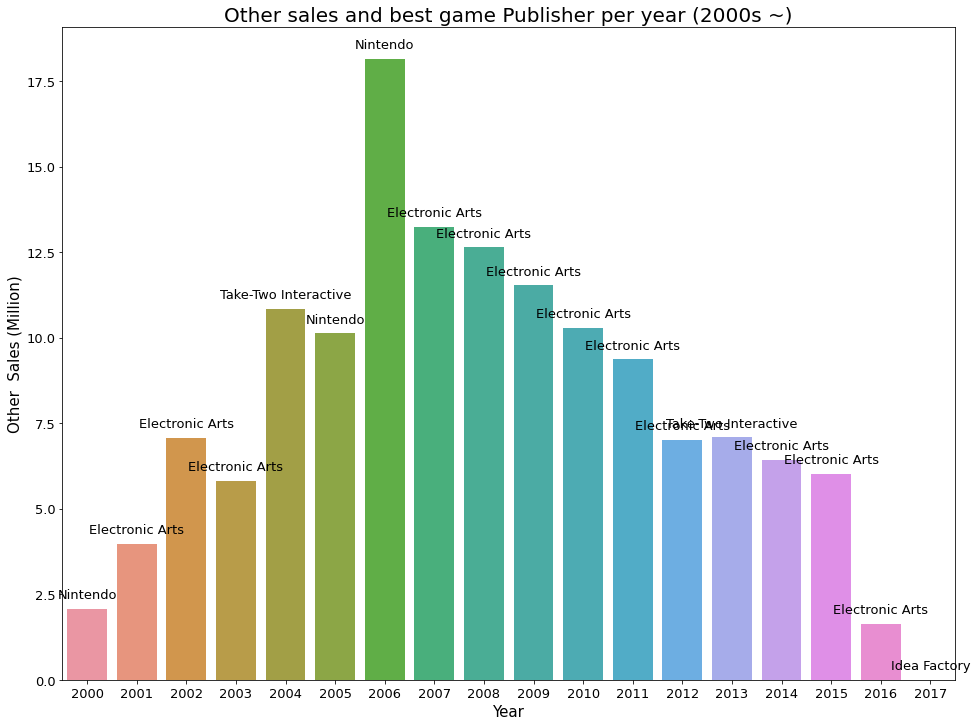

In [78]:
# 그 외지역
year_list = []
best_pub_list = []
sale_list = []

subset_year_pub =  df[df['Year']>=2000].groupby(['Year','Publisher']).sum()['Other_Sales'].reset_index()

for i in range(2000, 2018) :
    year_pub = subset_year_pub[subset_year_pub['Year'] == i].sort_values(by='Other_Sales',ascending=False).reset_index(drop=True)

    best_pub = year_pub.loc[0, 'Publisher']
    best_pub_sale =  year_pub.loc[0, 'Other_Sales']

    year_list.append(i)
    best_pub_list.append(best_pub)
    sale_list.append(best_pub_sale)
    
year_pub = pd.DataFrame((zip(year_list, best_pub_list, sale_list)), columns = ['Year', 'Best_Publisher', 'Other_Sales'])

fig, ax = plt.subplots(figsize=(16, 12))
bar = sns.barplot(x='Year', y='Other_Sales', data=year_pub)

for index, row in year_pub.iterrows():
    plt.text(index , row.Other_Sales + 0.3, str(row.Best_Publisher), color='black', ha="center", size=13)

ax.tick_params(labelsize=13)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Other  Sales (Million)', fontsize = 15)
plt.title('Other sales and best game Publisher per year (2000s ~)', fontsize = 20)
plt.show()

- 2013년도를 제외하고 2007 ~ 2016년도 까지는 Electronic Arts 가 매출이 가장 높았다.
- 2017년도 데이터는 수집한 양이 적기 때문에 통계량이 정확하지 않을것으로 보인다.

### 지역에 따라서 선호하는 게임 장르가 다를까?
- 지역은 어떻게 구분했나요?
- 지역별로 선호하는 게임의 장르를 파악했나요?
- 지역별로 선호하는 게임의 장르가 왜 같다고/다르다고 생각했나요?

### 연도별 게임의 트렌드가 있을까?
- 트렌드는 어떤 것을 기준으로 파악했나요?
- 연도별로 트렌드가 존재하나요?
- 왜 존재한다/존재하지 않는다고 생각했나요?

### 인기가 많은 게임에 대한 분석 및 시각화 프로세스?
- 인기가 많다는 것을 어떻게 정의했나요?
- 해당 게임이 왜 인기가 많다고 생각했나요?
- 시각화를 통해 무엇을 나타내고자 하는지를 고려했나요?
- 해당 분석을 통해 어떤 인사이트를 도출할 수 있나요?

### 다음 분기에 어떤 게임을 설계해야 하는지에 대한 결론이 제시되어야 함.
- 다음 분기가 언제인지
- 회사의 규모는 어느정도인지
- 와 같은 디테일한 상황 설정과 더불어 '왜' 이러한 결론을 도출하였는지에 대한 고민이 필요합니다.

In [86]:
df[(df['Year']>=2000) & (df['Genre'] == 'Shooter') & (df['Publisher'] == 'Electronic Arts')].groupby(['Name', 'Genre', 'Publisher']).sum().sort_values(by='Total_Sales',ascending=False).reset_index()

,Name,Genre,Publisher,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Multiplatform
0,Battlefield 3,Shooter,Electronic Arts,6033,8.20,6.49,0.41,2.27,17.37,3
1,Battlefield 4,Shooter,Electronic Arts,10065,6.41,5.57,0.46,1.60,14.04,5
2,Star Wars Battlefront (2015),Shooter,Electronic Arts,6045,5.00,4.88,0.24,1.58,11.70,3
3,Medal of Honor: Frontline,Shooter,Electronic Arts,6006,4.39,3.30,0.17,1.07,8.93,3
4,Battlefield: Bad Company 2,Shooter,Electronic Arts,6030,3.61,2.67,0.12,0.77,7.17,3
...,...,...,...,...,...,...,...,...,...,...
58,Battlefield 1942,Shooter,Electronic Arts,2002,0.01,0.01,0.00,0.00,0.02,0
59,Battlefield 2142,Shooter,Electronic Arts,2006,0.00,0.02,0.00,0.00,0.02,0
60,Battlefield Vietnam,Shooter,Electronic Arts,2004,0.00,0.02,0.00,0.00,0.02,0
61,Battlefield 2: Modern Combat(JP sales),Shooter,Electronic Arts,2005,0.00,0.00,0.02,0.00,0.02,0
